## Dataset : Cornell Movie Review Data

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
from tqdm.auto import tqdm
import random
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import os
from sklearn.metrics import f1_score, recall_score, precision_score
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from itertools import product
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
from itertools import product

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#!pip install --upgrade tensorflow

In [6]:
!wget https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz


--2024-02-13 09:47:15--  https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  5.00MB/s    in 0.6s    

2024-02-13 09:47:16 (5.00 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [7]:
!tar xvzf review_polarity.tar.gz


txt_sentoken/neg/cv000_29416.txt
txt_sentoken/neg/cv001_19502.txt
txt_sentoken/neg/cv002_17424.txt
txt_sentoken/neg/cv003_12683.txt
txt_sentoken/neg/cv004_12641.txt
txt_sentoken/neg/cv005_29357.txt
txt_sentoken/neg/cv006_17022.txt
txt_sentoken/neg/cv007_4992.txt
txt_sentoken/neg/cv008_29326.txt
txt_sentoken/neg/cv009_29417.txt
txt_sentoken/neg/cv010_29063.txt
txt_sentoken/neg/cv011_13044.txt
txt_sentoken/neg/cv012_29411.txt
txt_sentoken/neg/cv013_10494.txt
txt_sentoken/neg/cv014_15600.txt
txt_sentoken/neg/cv015_29356.txt
txt_sentoken/neg/cv016_4348.txt
txt_sentoken/neg/cv017_23487.txt
txt_sentoken/neg/cv018_21672.txt
txt_sentoken/neg/cv019_16117.txt
txt_sentoken/neg/cv020_9234.txt
txt_sentoken/neg/cv021_17313.txt
txt_sentoken/neg/cv022_14227.txt
txt_sentoken/neg/cv023_13847.txt
txt_sentoken/neg/cv024_7033.txt
txt_sentoken/neg/cv025_29825.txt
txt_sentoken/neg/cv026_29229.txt
txt_sentoken/neg/cv027_26270.txt
txt_sentoken/neg/cv028_26964.txt
txt_sentoken/neg/cv029_19943.txt
txt_sentoken/n

In [8]:
import os
from sklearn.datasets import load_files


dataset_path = 'txt_sentoken'
movie_reviews = load_files(container_path = dataset_path, encoding = 'utf-8')


x = movie_reviews.data            #the data
y = movie_reviews.target          #the labels
z = movie_reviews.target_names    #the names of labels

In [9]:
x[:1]

["arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [10]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [11]:
z

['neg', 'pos']

## Average Document Length

In [12]:
len(x)

2000

In [13]:
len(x[0])

3126

In [14]:
def average_doc_length(corpus):
    ''' Takes as input a whole corpus
      Returns the average number of words and chars per document '''

    document_word_lengths = [len(doc.split()) for doc in corpus]                            #length of each doc (in words)
    average_doc_length_words = sum(document_word_lengths) / len(document_word_lengths)      #average doc length (in words)

    document_char_lengths = [len(doc) for doc in corpus]                                    #length of each doc (in characters)
    average_doc_length_chars = sum(document_char_lengths) / len(document_char_lengths)      #average doc length (in characters)

    return average_doc_length_words, average_doc_length_chars

In [15]:
#from common import average_doc_length
print("---Before preprocessing---")
avg_length_words, avg_length_chars = average_doc_length(x)
print("Average Document Length (in words):", avg_length_words)
print("Average Document Length (in characters):", avg_length_chars)

---Before preprocessing---
Average Document Length (in words): 746.3405
Average Document Length (in characters): 3893.002


## Pre processing

Let's take a look at the 100 most frequent words:

In [16]:
text = ' '.join(x)
tokens = word_tokenize(text.lower())              #convert to lowercase to treat words case-insensitively
#tokens = [token.lower() for token in x]
word_counts = Counter(tokens)
top_100_words = word_counts.most_common(100)

for word, count in top_100_words:
  print(f"{word}: {count} occurrences")

,: 77717 occurrences
the: 76276 occurrences
.: 65876 occurrences
a: 37995 occurrences
and: 35404 occurrences
of: 33972 occurrences
to: 31772 occurrences
is: 26054 occurrences
in: 21611 occurrences
's: 18128 occurrences
``: 17625 occurrences
it: 16059 occurrences
that: 15912 occurrences
): 11781 occurrences
(: 11664 occurrences
as: 11349 occurrences
with: 10782 occurrences
for: 9918 occurrences
this: 9573 occurrences
his: 9569 occurrences
film: 9443 occurrences
i: 8850 occurrences
he: 8840 occurrences
but: 8604 occurrences
on: 7249 occurrences
are: 7204 occurrences
by: 6218 occurrences
n't: 6217 occurrences
be: 6083 occurrences
an: 5742 occurrences
who: 5680 occurrences
not: 5672 occurrences
movie: 5671 occurrences
one: 5582 occurrences
you: 5286 occurrences
was: 5225 occurrences
have: 5046 occurrences
from: 4987 occurrences
at: 4972 occurrences
they: 4815 occurrences
has: 4811 occurrences
her: 4508 occurrences
all: 4259 occurrences
?: 3771 occurrences
there: 3758 occurrences
so: 3585 o

The english stopwords is a package of 179 words that in general, would not help in a sentiment analysis problem. But, since they include terms that are negative, removing them could prove harmful for our case.

e.g. imagine the phrase "I didn't like the film" to end up "like film".

So, the plan is to remove all the stop words that include negative meaning before the preprocessing.

In [17]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

 From these words, we will decide which ones to keep because in fact they have a meaningful impact in our sentiment analysis problem, as we stated earlier.

In [18]:
set_stop_words = set(stopwords.words('english'))
set_x = set(tokens)
to_keep_words = ['not', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't" , "shouldn't", "haven't", "wasn't", "weren't",  "isn't", "doesn"]
to_keep_words

['not',
 "don't",
 "aren't",
 "couldn't",
 "didn't",
 "doesn't",
 "hadn't",
 "hasn't",
 "shouldn't",
 "haven't",
 "wasn't",
 "weren't",
 "isn't",
 'doesn']

In [19]:
stopwords_updated = set(stopwords.words('english')) - set(to_keep_words)
print(len(stopwords.words('english')))
print(len(to_keep_words))
print(len(stopwords_updated))

179
14
165


In [20]:
def pre_process_text(text):
    ''' Function to preprocess text.
     input: initial text
     output: processed text
     Performs pre-processing methods:
        1. Combination to a single document.
        2. Convertion to lowercase.
        3. Lemmatization and stop words extraction
        4. Punctuation removal
        5. Number removal
        6. Single characters removal
        7. Converting multiple spaces to single ones
        '''
    lemmatizer = WordNetLemmatizer()
    all_docs = []

    single_char = re.compile(r'\s+[a-z]\s+')                                          #6. Remove single characters
    multiple_space= re.compile(r'\s+')                                                 #7. Replace multiple space with a single one

    stopwords_updated = set(stopwords.words('english')) - set(to_keep_words)
    for document in tqdm(x):

        combined_text = ' '.join(text)            #1.Combine in one single document

        combined_text = combined_text.lower()    #2. Convert to lowercase
        combined_text = [lemmatizer.lemmatize(word) for word in document.split() if word not in stopwords_updated]  # 3.Lemmatize and remove stop words


        combined_text = ' '.join(combined_text)

        combined_text = ''.join([char for char in combined_text if char not in string.punctuation])   #4.remove punctuation
        combined_text = ''.join([char for char in combined_text if not char.isdigit()])     #5.remove numbers

        res = single_char.sub(combined_text, '')
        res2 = multiple_space.sub(combined_text, ' ')
        all_docs.append(combined_text)

    return all_docs

In [21]:
processed_text = pre_process_text(x)

processed_text[:1]

  0%|          | 0/2000 [00:00<?, ?it/s]

['arnold schwarzenegger icon action enthusiast  since late s  lately film sloppy oneliner getting worse  hard seeing arnold mr  freeze batman robin  especially say ton ice joke  hey got  million  whats matter  arnold signed another expensive blockbuster  cant compare like terminator series  true lie even eraser  called dark thriller  devil  gabriel byrne  come upon earth  impregnate woman  robin tunney  happens every  year  basically destroy world  apparently god chosen one man  one man jericho cane  arnold   help trusty sidekick  kevin pollack   stop nothing let devil take world  part actually absurd  would fit right dogma  yes  film weak  better blockbuster right  sleepy hollow   make world not enough look like  star film  anyway  definitely doesnt seem like arnold movie  wasnt type film see  sure gave u chuckle well known oneliner  seemed confused character film going  understandable  especially ending changed according source  aside form  still walked  much like past film  im sorry

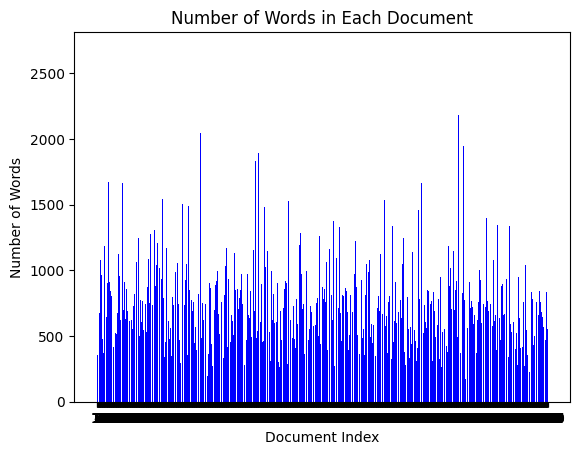

In [22]:
word_counts = [len(doc.split()) for doc in x]

# Plotting
plt.bar(range(len(word_counts)), word_counts, color='blue')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.title('Number of Words in Each Document')
plt.xticks(range(len(word_counts)), range(1, len(word_counts)+1))
plt.show()

## Splitting into training set (70%), development set (15%) and test set (15%)

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(processed_text, y, test_size=0.3, random_state=17)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=25)

training_text = ' '.join(X_train)                    #Flatten into a single string
development_text = ' '.join(X_dev)
test_text = ' '.join(X_test)

training_words = training_text.split()
development_words = development_text.split()
test_words = test_text.split()

training_vocab = set(training_words)
development_vocab = set(development_words)
test_vocab = set(test_words)

In [24]:
print("Training set size (in documents): ", len(y_train))
print("Development set size (in documents): ", len(y_dev))
print("Test set size (in documents): ", len(y_test))
print("Full size (sanity check): ", len(y_train) + len(y_dev) + len(y_test))
print("---------------------------------")
print("Training vocabulary size (in words): " , len(training_vocab))
print("Development vocabulary size (in words): ", len(development_vocab))
print("Test vocabulary size (in words): ", len(test_vocab))
print("Full vocabulary size (in words): ", len(training_vocab) + len(development_vocab) + len(test_vocab))

Training set size (in documents):  1400
Development set size (in documents):  300
Test set size (in documents):  300
Full size (sanity check):  2000
---------------------------------
Training vocabulary size (in words):  36624
Development vocabulary size (in words):  16948
Test vocabulary size (in words):  16780
Full vocabulary size (in words):  70352


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2),                                        #Using unigram and bigram tf-idf features
                             max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

print("Shape (training data): ", X_train_tfidf.shape)
print("Shape (development data): ", X_dev_tfidf.shape)
print("Shape (test data): ", X_test_tfidf.shape)

Shape (training data):  (1400, 5000)
Shape (development data):  (300, 5000)
Shape (test data):  (300, 5000)


Below we can see that X_test_tfidf is a sparse array, keeping only the non-zero elements. We demonstrate all the elements in the first document with their corresponding TFIDF weights.

In [26]:
print("(#Doc,col index)     weight")
print("--------------------------------------------")
print(X_test_tfidf[0, :])

(#Doc,col index)     weight
--------------------------------------------
  (0, 4988)	0.04369979111445381
  (0, 4984)	0.04509572589709288
  (0, 4949)	0.029438259695493924
  (0, 4944)	0.056137163964358784
  (0, 4824)	0.05057974628634809
  (0, 4818)	0.04691105533946471
  (0, 4813)	0.044492208704761484
  (0, 4809)	0.05686119775889408
  (0, 4752)	0.05958423412364823
  (0, 4745)	0.0545816762790642
  (0, 4738)	0.055935407908133075
  (0, 4602)	0.04369979111445381
  (0, 4547)	0.059221065124916185
  (0, 4503)	0.08881260047092368
  (0, 4501)	0.06533835593131196
  (0, 4494)	0.08320647266960984
  (0, 4483)	0.05583535077757744
  (0, 4468)	0.03918145513118411
  (0, 4397)	0.11107231660960269
  (0, 4360)	0.03126951709001394
  (0, 4306)	0.10415507060882424
  (0, 4231)	0.09278366310364763
  (0, 4229)	0.049964847720078163
  (0, 4217)	0.0896171685791907
  (0, 4202)	0.09205962930911232
  :	:
  (0, 513)	0.060849146279275595
  (0, 489)	0.08036077475459913
  (0, 488)	0.053672108305792124
  (0, 442)	0.084107163

In [27]:
x_train_tfidf_array = X_train_tfidf.toarray()                   #from sparse to dense
x_dev_tfidf_array = X_dev_tfidf.toarray()
x_test_tfidf_array = X_test_tfidf.toarray()


## Reducing dimensionality using SVD (from 5000 ---> 500 features)

In [28]:
svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(x_train_tfidf_array)
X_dev_svd = svd.transform(x_dev_tfidf_array)
X_test_svd = svd.transform(x_test_tfidf_array)

print("Shape (training data) after SVD: ", X_train_svd.shape)
print("Shape (development data) after SVD: ", X_dev_svd.shape)
print("Shape (test data) after SVD: ", X_test_svd.shape)

Shape (training data) after SVD:  (1400, 500)
Shape (development data) after SVD:  (300, 500)
Shape (test data) after SVD:  (300, 500)


In [29]:
len(X_test_svd[0,:]) == 500     #Sanity check if the dimension is 500

True

## Dummy Classifier

In [30]:
dummy_clf = DummyClassifier(strategy="most_frequent") #assigns the most frequent class
dummy_clf.fit(X_train_svd, y_train)


y_dev_pred = dummy_clf.predict(X_dev_svd)

#classification report -- Development set
print("Classification Report on Development Set:")
print(classification_report(y_dev, y_dev_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Training set
y_train_pred = dummy_clf.predict(X_train_svd)
print("Classification Report on Training Set:")
print(classification_report(y_train, y_train_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Test set
y_test_pred = dummy_clf.predict(X_test_svd)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=z))

Classification Report on Development Set:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       157
         pos       0.48      1.00      0.65       143

    accuracy                           0.48       300
   macro avg       0.24      0.50      0.32       300
weighted avg       0.23      0.48      0.31       300

-----------------------------------------------------
Classification Report on Training Set:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       690
         pos       0.51      1.00      0.67       710

    accuracy                           0.51      1400
   macro avg       0.25      0.50      0.34      1400
weighted avg       0.26      0.51      0.34      1400

-----------------------------------------------------
Classification Report on Test Set:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       153
         pos 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

## Logistic Regression

In [31]:
parameters = {
    'solver': ['liblinear', 'saga'],  #solvers to try
    'penalty': ['l1', 'l2', 'elasticnet'],  #reguralization penalties
    'C': [0.001, 0.01, 0.1, 1, 10],  #inverse of regularization strength
}

log_clf = LogisticRegression()
log_grid_clf = GridSearchCV(log_clf, parameters, cv=5, scoring='accuracy', verbose=1)

log_grid_clf.fit(X_train_svd, y_train)
print("Best hyperparameters:", log_grid_clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueError(
ValueError: Only

In [32]:
best_clf = log_grid_clf.best_estimator_
best_clf

LogisticRegression(C=1, solver='liblinear')

In [33]:
best_clf.fit(X_train_svd, y_train)

#classification report -- Training set
y_train_pred = best_clf.predict(X_train_svd)
print("Classification Report on Training Set:")
print(classification_report(y_train, y_train_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Development set
y_dev_pred = best_clf.predict(X_dev_svd)
print("\nClassification Report on Development Set:")
print(classification_report(y_dev, y_dev_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Test set
y_test_pred = best_clf.predict(X_test_svd)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=z))

Classification Report on Training Set:
              precision    recall  f1-score   support

         neg       0.94      0.92      0.93       690
         pos       0.92      0.94      0.93       710

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400

-----------------------------------------------------

Classification Report on Development Set:
              precision    recall  f1-score   support

         neg       0.90      0.82      0.85       157
         pos       0.82      0.90      0.85       143

    accuracy                           0.85       300
   macro avg       0.86      0.86      0.85       300
weighted avg       0.86      0.85      0.85       300

-----------------------------------------------------
Classification Report on Test Set:
              precision    recall  f1-score   support

         neg       0.88      0.81      0.84       153
         pos

## Creating one-hot vectors

In [34]:
lb = LabelBinarizer()
target_list = z

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_dev_1_hot = lb.transform([target_list[x] for x in y_dev])

#y_train_1_hot = np.argmax(y_train_1_hot, axis=1)
#y_dev_1_hot = np.argmax(y_dev_1_hot, axis=1)

print('y_dev_1_hot: {}'.format(y_dev_1_hot))

y_dev_1_hot: [[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [

In [35]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

## Setting our MLP model

In [54]:
def MLP(input_size, num_hid_layers, hid_layers_size, drop_prob, batch_size, learn_rate):


  model = Sequential()
  model.add(Dense(input_size, input_dim=X_train_svd.shape[1] , activation='relu'))
  model.add(Dropout(drop_prob))

  for i in range(num_hid_layers):
    model.add(Dense(hid_layers_size, activation = 'relu'))
    model.add(Dropout(drop_prob))

  model.add(Dense(1,  activation='sigmoid'))

  # print(model.summary())

  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=learn_rate),
    metrics=["accuracy"]
    )

  if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

  checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_accuracy',
    mode='max',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

  start_training_time = time.time()
  history = model.fit(
      X_train_svd,
      y_train_1_hot,
      validation_data=(X_dev_svd, y_dev_1_hot),
      batch_size=batch_size,
      epochs=15,
      shuffle=True,
      callbacks=[Metrics(valid_data=(X_dev_svd, y_dev_1_hot)), checkpoint]
      )
  end_training_time = time.time()

  print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

  return history, model





## Hyperparameter Tuning

In [51]:
hyperparameters = {
    'learning_rate': [0.001, 0.01, 0.1],
    'hidden_layers': [1, 2],
    'hidden_layers_size': [64, 128],
    'dropout_prob': [0.4, 0.5],
    'batch_size': [1,64, 128]

}

In [52]:
best_dev_accuracy = -1
best_hyperparameters = None

hyperparameter_combinations = list(product(*hyperparameters.values()))
for params in hyperparameter_combinations:
    learning_rate, hidden_layers, hidden_layers_size, dropout_prob, batch_size = params

    print(f"\nTraining with hyperparameters: {params}")

    history, model = MLP(256, hidden_layers, hidden_layers_size, dropout_prob, batch_size)


    dev_loss, dev_accuracy = model.evaluate(X_dev_svd, y_dev_1_hot)             #evaluate model on the development set

    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_hyperparameters = params
    print(f"Development Accuracy: {dev_accuracy}")



Training with hyperparameters: (0.001, 1, 64, 0.4, 1)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6925 - accuracy: 0.5043 - val_loss: 0.6921 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  73/1400 [>.............................] - ETA: 2s - loss: 0.6924 - accuracy: 0.5205

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.72667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 3s 2ms/step - loss: 0.6857 - accuracy: 0.5543 - val_loss: 0.6761 - val_accuracy: 0.7267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  76/1400 [>.............................] - ETA: 2s - loss: 0.6725 - accuracy: 0.5658

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.72667 to 0.81333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 3s 2ms/step - loss: 0.6698 - accuracy: 0.5886 - val_loss: 0.6518 - val_accuracy: 0.8133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  80/1400 [>.............................] - ETA: 2s - loss: 0.6319 - accuracy: 0.7000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.81333 to 0.85000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6284 - accuracy: 0.6757 - val_loss: 0.5937 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  69/1400 [>.............................] - ETA: 2s - loss: 0.6290 - accuracy: 0.6522

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5650 - accuracy: 0.7243 - val_loss: 0.5066 - val_accuracy: 0.8400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  77/1400 [>.............................] - ETA: 2s - loss: 0.5361 - accuracy: 0.7403

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.85000 to 0.86667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4679 - accuracy: 0.7921 - val_loss: 0.4082 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  72/1400 [>.............................] - ETA: 2s - loss: 0.3737 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3829 - accuracy: 0.8436 - val_loss: 0.3739 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.2918 - accuracy: 0.8333

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.86667 to 0.88667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3215 - accuracy: 0.8750 - val_loss: 0.3285 - val_accuracy: 0.8867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  71/1400 [>.............................] - ETA: 2s - loss: 0.3413 - accuracy: 0.8732

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3010 - accuracy: 0.8729 - val_loss: 0.4406 - val_accuracy: 0.7833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  71/1400 [>.............................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8732

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2684 - accuracy: 0.8886 - val_loss: 0.3677 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  43/1400 [..............................] - ETA: 4s - loss: 0.2520 - accuracy: 0.8837

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2449 - accuracy: 0.8950 - val_loss: 0.3398 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  78/1400 [>.............................] - ETA: 2s - loss: 0.2546 - accuracy: 0.8718

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2155 - accuracy: 0.9186 - val_loss: 0.2898 - val_accuracy: 0.8867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  68/1400 [>.............................] - ETA: 2s - loss: 0.1307 - accuracy: 0.9706

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2004 - accuracy: 0.9143 - val_loss: 0.3176 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  69/1400 [>.............................] - ETA: 2s - loss: 0.1699 - accuracy: 0.9565

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.1907 - accuracy: 0.9200 - val_loss: 0.2854 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  76/1400 [>.............................] - ETA: 2s - loss: 0.1519 - accuracy: 0.9474

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1698 - accuracy: 0.9386 - val_loss: 0.3025 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:59 sec

 1/10 [==>...........................] - ETA: 1s - loss: 0.4904 - accuracy: 0.8438

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.3025 - accuracy: 0.8800
Development Accuracy: 0.8799999952316284

Training with hyperparameters: (0.001, 1, 64, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.55667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 21ms/step - loss: 0.6942 - accuracy: 0.4864 - val_loss: 0.6928 - val_accuracy: 0.5567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6937 - accuracy: 0.4870

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.55667 to 0.57000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6933 - accuracy: 0.5050 - val_loss: 0.6928 - val_accuracy: 0.5700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5045

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 11ms/step - loss: 0.6933 - accuracy: 0.4964 - val_loss: 0.6928 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6934 - accuracy: 0.4900

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.4936 - val_loss: 0.6928 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6935 - accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 13ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.57000
22/22 [==============================] - 1s 25ms/step - loss: 0.6937 - accuracy: 0.4864 - val_loss: 0.6928 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6928 - accuracy: 0.4951

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 22ms/step - loss: 0.6934 - accuracy: 0.4936 - val_loss: 0.6928 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6933 - accuracy: 0.4911

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.4993 - val_loss: 0.6928 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6946 - accuracy: 0.4866

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 13ms/step - loss: 0.6945 - accuracy: 0.4943 - val_loss: 0.6928 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 12ms/step - loss: 0.6920 - accuracy: 0.5329 - val_loss: 0.6928 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5335

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 12ms/step - loss: 0.6927 - accuracy: 0.5150 - val_loss: 0.6928 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6935 - accuracy: 0.5049

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 18ms/step - loss: 0.6932 - accuracy: 0.5114 - val_loss: 0.6928 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6930 - accuracy: 0.5099

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 17ms/step - loss: 0.6928 - accuracy: 0.5121 - val_loss: 0.6928 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6924 - accuracy: 0.5138

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 17ms/step - loss: 0.6927 - accuracy: 0.5057 - val_loss: 0.6928 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6927 - accuracy: 0.5094

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 19ms/step - loss: 0.6926 - accuracy: 0.5136 - val_loss: 0.6927 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5217

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.57000
22/22 [==============================] - 0s 18ms/step - loss: 0.6925 - accuracy: 0.5143 - val_loss: 0.6927 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Development Accuracy: 0.47999998927116394

Training with hyperparameters: (0.001, 1, 64, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 45ms/step - loss: 0.6935 - accuracy: 0.4914 - val_loss: 0.6941 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4929

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.48333 to 0.48667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 26ms/step - loss: 0.6935 - accuracy: 0.4929 - val_loss: 0.6941 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.48667 to 0.49000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.4964 - val_loss: 0.6940 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
11/11 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5114

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.49000
11/11 [==============================] - 0s 21ms/step - loss: 0.6934 - accuracy: 0.5114 - val_loss: 0.6940 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.49000 to 0.50000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 25ms/step - loss: 0.6923 - accuracy: 0.5071 - val_loss: 0.6940 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.50000
11/11 [==============================] - 0s 21ms/step - loss: 0.6935 - accuracy: 0.4786 - val_loss: 0.6940 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
10/10 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.50000
11/11 [==============================] - 0s 22ms/step - loss: 0.6918 - accuracy: 0.5179 - val_loss: 0.6940 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.50000
11/11 [==============================] - 0s 24ms/step - loss: 0.6929 - accuracy: 0.5057 - val_loss: 0.6939 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
10/10 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.50000
11/11 [==============================] - 0s 20ms/step - loss: 0.6928 - accuracy: 0.5064 - val_loss: 0.6939 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.50000 to 0.50333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 25ms/step - loss: 0.6917 - accuracy: 0.5243 - val_loss: 0.6938 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
11/11 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.4986

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 22ms/step - loss: 0.6929 - accuracy: 0.4986 - val_loss: 0.6938 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 21ms/step - loss: 0.6925 - accuracy: 0.5100 - val_loss: 0.6938 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
10/10 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 22ms/step - loss: 0.6918 - accuracy: 0.5193 - val_loss: 0.6937 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 23ms/step - loss: 0.6920 - accuracy: 0.5193 - val_loss: 0.6937 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 21ms/step - loss: 0.6924 - accuracy: 0.4971 - val_loss: 0.6937 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:04 sec

10/10 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.5000
Development Accuracy: 0.5

Training with hyperparameters: (0.001, 1, 64, 0.5, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6950 - accuracy: 0.4943 - val_loss: 0.6925 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  72/1400 [>.............................] - ETA: 2s - loss: 0.6999 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.47667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6909 - accuracy: 0.5300 - val_loss: 0.6868 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  78/1400 [>.............................] - ETA: 2s - loss: 0.6848 - accuracy: 0.4872

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.47667 to 0.55333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6855 - accuracy: 0.5443 - val_loss: 0.6764 - val_accuracy: 0.5533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.6572 - accuracy: 0.6308

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.55333 to 0.82667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6696 - accuracy: 0.6150 - val_loss: 0.6477 - val_accuracy: 0.8267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  79/1400 [>.............................] - ETA: 2s - loss: 0.6589 - accuracy: 0.6456

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.82667 to 0.84000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6455 - accuracy: 0.6457 - val_loss: 0.6009 - val_accuracy: 0.8400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  78/1400 [>.............................] - ETA: 2s - loss: 0.5944 - accuracy: 0.7436

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.84000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5929 - accuracy: 0.7086 - val_loss: 0.5262 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  69/1400 [>.............................] - ETA: 2s - loss: 0.5009 - accuracy: 0.8116

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.84000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4994 - accuracy: 0.7843 - val_loss: 0.6022 - val_accuracy: 0.6033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  78/1400 [>.............................] - ETA: 2s - loss: 0.5133 - accuracy: 0.7692

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.84000 to 0.86667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4441 - accuracy: 0.7943 - val_loss: 0.3635 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  46/1400 [..............................] - ETA: 4s - loss: 0.4184 - accuracy: 0.7826

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3683 - accuracy: 0.8457 - val_loss: 0.3884 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  70/1400 [>.............................] - ETA: 2s - loss: 0.5202 - accuracy: 0.7429

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3396 - accuracy: 0.8643 - val_loss: 0.3707 - val_accuracy: 0.8133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  73/1400 [>.............................] - ETA: 2s - loss: 0.3379 - accuracy: 0.8219

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3100 - accuracy: 0.8629 - val_loss: 0.3486 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  68/1400 [>.............................] - ETA: 3s - loss: 0.1951 - accuracy: 0.9412

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.86667 to 0.87000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2793 - accuracy: 0.8893 - val_loss: 0.3237 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  75/1400 [>.............................] - ETA: 2s - loss: 0.2024 - accuracy: 0.9467

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2540 - accuracy: 0.8936 - val_loss: 0.3009 - val_accuracy: 0.8633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  73/1400 [>.............................] - ETA: 2s - loss: 0.2145 - accuracy: 0.9315

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.87000 to 0.89333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2526 - accuracy: 0.8964 - val_loss: 0.2883 - val_accuracy: 0.8933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  43/1400 [..............................] - ETA: 5s - loss: 0.2422 - accuracy: 0.9070

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.89333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2225 - accuracy: 0.9014 - val_loss: 0.2855 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8833
Development Accuracy: 0.8833333253860474

Training with hyperparameters: (0.001, 1, 64, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.49000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 24ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6940 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.4978

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.49000 to 0.49333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6934 - accuracy: 0.4964 - val_loss: 0.6939 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6942 - accuracy: 0.5022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.49333 to 0.50333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6935 - accuracy: 0.5079 - val_loss: 0.6938 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
13/22 [================>.............] - ETA: 0s - loss: 0.6934 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5114 - val_loss: 0.6936 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6926 - accuracy: 0.5065

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6935 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6948 - accuracy: 0.4877

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.50333 to 0.50667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 13ms/step - loss: 0.6943 - accuracy: 0.4907 - val_loss: 0.6933 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6947 - accuracy: 0.4906

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 13ms/step - loss: 0.6947 - accuracy: 0.4921 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
13/22 [================>.............] - ETA: 0s - loss: 0.6890 - accuracy: 0.5541

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 11ms/step - loss: 0.6915 - accuracy: 0.5229 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 12ms/step - loss: 0.6942 - accuracy: 0.5079 - val_loss: 0.6928 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
13/22 [================>.............] - ETA: 0s - loss: 0.6941 - accuracy: 0.4976

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.5086 - val_loss: 0.6927 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
13/22 [================>.............] - ETA: 0s - loss: 0.6924 - accuracy: 0.5024

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.50667 to 0.51000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5086 - val_loss: 0.6927 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6944 - accuracy: 0.4788

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.51000 to 0.51333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 12ms/step - loss: 0.6936 - accuracy: 0.4900 - val_loss: 0.6925 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
13/22 [================>.............] - ETA: 0s - loss: 0.6926 - accuracy: 0.5228

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.51333 to 0.52000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6922 - accuracy: 0.5200 - val_loss: 0.6924 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
14/22 [==================>...........] - ETA: 0s - loss: 0.6940 - accuracy: 0.5067

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.52000 to 0.52333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6943 - accuracy: 0.5021 - val_loss: 0.6923 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
13/22 [================>.............] - ETA: 0s - loss: 0.6933 - accuracy: 0.5108

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6922 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5100


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Development Accuracy: 0.5099999904632568

Training with hyperparameters: (0.001, 1, 64, 0.5, 128)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 42ms/step - loss: 0.6925 - accuracy: 0.5121 - val_loss: 0.6927 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6941 - accuracy: 0.4914

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
11/11 [==============================] - 0s 22ms/step - loss: 0.6934 - accuracy: 0.4993 - val_loss: 0.6927 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52333
11/11 [==============================] - 0s 24ms/step - loss: 0.6955 - accuracy: 0.4736 - val_loss: 0.6927 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
10/10 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.52333 to 0.53333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 21ms/step - loss: 0.6925 - accuracy: 0.5036 - val_loss: 0.6927 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
11/11 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5164

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 27ms/step - loss: 0.6931 - accuracy: 0.5164 - val_loss: 0.6927 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 22ms/step - loss: 0.6922 - accuracy: 0.5179 - val_loss: 0.6927 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 21ms/step - loss: 0.6936 - accuracy: 0.5107 - val_loss: 0.6927 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 23ms/step - loss: 0.6941 - accuracy: 0.4850 - val_loss: 0.6927 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6919 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 32ms/step - loss: 0.6921 - accuracy: 0.5243 - val_loss: 0.6927 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6922 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.53333 to 0.54667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 33ms/step - loss: 0.6922 - accuracy: 0.5264 - val_loss: 0.6927 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6919 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.54667 to 0.56000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 32ms/step - loss: 0.6918 - accuracy: 0.5229 - val_loss: 0.6927 - val_accuracy: 0.5600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6943 - accuracy: 0.4955

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.56000
11/11 [==============================] - 0s 32ms/step - loss: 0.6932 - accuracy: 0.5057 - val_loss: 0.6927 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
11/11 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5079

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.56000
11/11 [==============================] - 0s 35ms/step - loss: 0.6925 - accuracy: 0.5079 - val_loss: 0.6927 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.56000
11/11 [==============================] - 0s 35ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6927 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6918 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.56000
11/11 [==============================] - 0s 36ms/step - loss: 0.6927 - accuracy: 0.5071 - val_loss: 0.6927 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5167
Development Accuracy: 0.5166666507720947

Training with hyperparameters: (0.001, 1, 128, 0.4, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6930 - accuracy: 0.5136 - val_loss: 0.6892 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  66/1400 [>.............................] - ETA: 3s - loss: 0.6827 - accuracy: 0.6061

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.48000 to 0.57333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6823 - accuracy: 0.5786 - val_loss: 0.6746 - val_accuracy: 0.5733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  71/1400 [>.............................] - ETA: 2s - loss: 0.6642 - accuracy: 0.6479

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.57333 to 0.64667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6678 - accuracy: 0.6086 - val_loss: 0.6559 - val_accuracy: 0.6467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6387 - accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.64667 to 0.83333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6354 - accuracy: 0.6486 - val_loss: 0.5931 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.5581 - accuracy: 0.7846

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.83333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5415 - accuracy: 0.7507 - val_loss: 0.4930 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  60/1400 [>.............................] - ETA: 3s - loss: 0.4854 - accuracy: 0.7833

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.83333 to 0.85000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.4481 - accuracy: 0.7964 - val_loss: 0.4122 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.4396 - accuracy: 0.8095

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3795 - accuracy: 0.8386 - val_loss: 0.5191 - val_accuracy: 0.7267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  71/1400 [>.............................] - ETA: 2s - loss: 0.3582 - accuracy: 0.8592

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.85000 to 0.88000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3136 - accuracy: 0.8750 - val_loss: 0.3147 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.2006 - accuracy: 0.9385

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2803 - accuracy: 0.8821 - val_loss: 0.3630 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.3382 - accuracy: 0.7969

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.88000 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2456 - accuracy: 0.8943 - val_loss: 0.2948 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  69/1400 [>.............................] - ETA: 2s - loss: 0.2219 - accuracy: 0.9275

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2204 - accuracy: 0.9093 - val_loss: 0.3032 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  67/1400 [>.............................] - ETA: 3s - loss: 0.2500 - accuracy: 0.8955

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2222 - accuracy: 0.9114 - val_loss: 0.3666 - val_accuracy: 0.8400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  70/1400 [>.............................] - ETA: 2s - loss: 0.2446 - accuracy: 0.8857

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1892 - accuracy: 0.9200 - val_loss: 0.3212 - val_accuracy: 0.8633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  62/1400 [>.............................] - ETA: 3s - loss: 0.1425 - accuracy: 0.9516

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1757 - accuracy: 0.9293 - val_loss: 0.3224 - val_accuracy: 0.8600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  62/1400 [>.............................] - ETA: 3s - loss: 0.1108 - accuracy: 0.9839

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.1561 - accuracy: 0.9364 - val_loss: 0.2970 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.2970 - accuracy: 0.8833
Development Accuracy: 0.8833333253860474

Training with hyperparameters: (0.001, 1, 128, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.46333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 21ms/step - loss: 0.6948 - accuracy: 0.4893 - val_loss: 0.6938 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6959 - accuracy: 0.4561

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.46333
22/22 [==============================] - 0s 14ms/step - loss: 0.6958 - accuracy: 0.4614 - val_loss: 0.6938 - val_accuracy: 0.4367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
22/22 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.4893

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.46333 to 0.48000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 13ms/step - loss: 0.6945 - accuracy: 0.4893 - val_loss: 0.6937 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6945 - accuracy: 0.4831

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 15ms/step - loss: 0.6944 - accuracy: 0.4893 - val_loss: 0.6937 - val_accuracy: 0.4500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6942 - accuracy: 0.4797

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 20ms/step - loss: 0.6941 - accuracy: 0.4786 - val_loss: 0.6937 - val_accuracy: 0.4467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
22/22 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4836

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 19ms/step - loss: 0.6941 - accuracy: 0.4836 - val_loss: 0.6937 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
22/22 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4886

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 20ms/step - loss: 0.6939 - accuracy: 0.4886 - val_loss: 0.6936 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6943 - accuracy: 0.4770

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.48000 to 0.49333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 21ms/step - loss: 0.6943 - accuracy: 0.4743 - val_loss: 0.6936 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6936 - accuracy: 0.5020

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.49333
22/22 [==============================] - 0s 18ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
22/22 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4879

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.49333
22/22 [==============================] - 0s 18ms/step - loss: 0.6941 - accuracy: 0.4879 - val_loss: 0.6936 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6933 - accuracy: 0.5028

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.49333
22/22 [==============================] - 0s 12ms/step - loss: 0.6942 - accuracy: 0.4850 - val_loss: 0.6936 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
13/22 [================>.............] - ETA: 0s - loss: 0.6942 - accuracy: 0.4880

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.49333 to 0.49667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 13ms/step - loss: 0.6944 - accuracy: 0.4893 - val_loss: 0.6935 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6924 - accuracy: 0.5284

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.49667
22/22 [==============================] - 0s 12ms/step - loss: 0.6928 - accuracy: 0.5121 - val_loss: 0.6935 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6929 - accuracy: 0.5078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.49667
22/22 [==============================] - 0s 12ms/step - loss: 0.6934 - accuracy: 0.5086 - val_loss: 0.6934 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
13/22 [================>.............] - ETA: 0s - loss: 0.6923 - accuracy: 0.5144

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.49667
22/22 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6933 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4933
Development Accuracy: 0.4933333396911621

Training with hyperparameters: (0.001, 1, 128, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 43ms/step - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6929 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.53333 to 0.53667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 25ms/step - loss: 0.6929 - accuracy: 0.5036 - val_loss: 0.6929 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6945 - accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.53667 to 0.54000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 23ms/step - loss: 0.6946 - accuracy: 0.4829 - val_loss: 0.6929 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5361

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 24ms/step - loss: 0.6924 - accuracy: 0.5243 - val_loss: 0.6928 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 21ms/step - loss: 0.6936 - accuracy: 0.4957 - val_loss: 0.6928 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6930 - accuracy: 0.4965

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 23ms/step - loss: 0.6928 - accuracy: 0.4979 - val_loss: 0.6928 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6931 - accuracy: 0.5086

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.5093 - val_loss: 0.6928 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 21ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6928 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6930 - accuracy: 0.5047

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 25ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6927 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5026

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 27ms/step - loss: 0.6926 - accuracy: 0.5071 - val_loss: 0.6927 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
11/11 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 34ms/step - loss: 0.6926 - accuracy: 0.5107 - val_loss: 0.6927 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6935 - accuracy: 0.4961

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 32ms/step - loss: 0.6933 - accuracy: 0.4971 - val_loss: 0.6927 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6916 - accuracy: 0.5413

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 30ms/step - loss: 0.6924 - accuracy: 0.5314 - val_loss: 0.6926 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6922 - accuracy: 0.5130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 36ms/step - loss: 0.6920 - accuracy: 0.5193 - val_loss: 0.6926 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5134

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 32ms/step - loss: 0.6925 - accuracy: 0.5086 - val_loss: 0.6926 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5033
Development Accuracy: 0.503333330154419

Training with hyperparameters: (0.001, 1, 128, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6947 - accuracy: 0.4993 - val_loss: 0.6874 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  66/1400 [>.............................] - ETA: 3s - loss: 0.6927 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6886 - accuracy: 0.5493 - val_loss: 0.6898 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6704 - accuracy: 0.6406

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.63667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6769 - accuracy: 0.5914 - val_loss: 0.6657 - val_accuracy: 0.6367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  67/1400 [>.............................] - ETA: 3s - loss: 0.6634 - accuracy: 0.6269

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.63667 to 0.82000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6596 - accuracy: 0.6279 - val_loss: 0.6381 - val_accuracy: 0.8200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6410 - accuracy: 0.7031

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.82000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6237 - accuracy: 0.6850 - val_loss: 0.5768 - val_accuracy: 0.8100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  66/1400 [>.............................] - ETA: 3s - loss: 0.5984 - accuracy: 0.6970

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.82000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5562 - accuracy: 0.7293 - val_loss: 0.5752 - val_accuracy: 0.6433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.4613 - accuracy: 0.8095

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.82000 to 0.83667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4589 - accuracy: 0.7950 - val_loss: 0.4155 - val_accuracy: 0.8367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.3986 - accuracy: 0.8276

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.83667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3968 - accuracy: 0.8379 - val_loss: 0.6900 - val_accuracy: 0.6167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.4470 - accuracy: 0.7460

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.83667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3576 - accuracy: 0.8464 - val_loss: 0.4212 - val_accuracy: 0.8000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.2916 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.83667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3160 - accuracy: 0.8671 - val_loss: 0.4042 - val_accuracy: 0.8100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.2945 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.83667 to 0.87667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2731 - accuracy: 0.8850 - val_loss: 0.3033 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.1967 - accuracy: 0.9153

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.87667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2653 - accuracy: 0.8921 - val_loss: 0.3073 - val_accuracy: 0.8633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.1993 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.87667 to 0.89000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2285 - accuracy: 0.9043 - val_loss: 0.2967 - val_accuracy: 0.8900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.3806 - accuracy: 0.8393

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2148 - accuracy: 0.9121 - val_loss: 0.4363 - val_accuracy: 0.8267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  67/1400 [>.............................] - ETA: 3s - loss: 0.1747 - accuracy: 0.9254

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.1957 - accuracy: 0.9257 - val_loss: 0.4127 - val_accuracy: 0.8300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:05 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.4127 - accuracy: 0.8300
Development Accuracy: 0.8299999833106995

Training with hyperparameters: (0.001, 1, 128, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 22ms/step - loss: 0.6937 - accuracy: 0.5007 - val_loss: 0.6929 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5063

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5114 - val_loss: 0.6928 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
22/22 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.52667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6935 - accuracy: 0.5107 - val_loss: 0.6928 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
22/22 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4857

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 13ms/step - loss: 0.6941 - accuracy: 0.4857 - val_loss: 0.6928 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
22/22 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5236

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 13ms/step - loss: 0.6916 - accuracy: 0.5236 - val_loss: 0.6928 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5097

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 15ms/step - loss: 0.6931 - accuracy: 0.5093 - val_loss: 0.6927 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6916 - accuracy: 0.5365

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6918 - accuracy: 0.5293 - val_loss: 0.6926 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6943 - accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 13ms/step - loss: 0.6935 - accuracy: 0.5057 - val_loss: 0.6926 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6935 - accuracy: 0.5026

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6938 - accuracy: 0.4986 - val_loss: 0.6925 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6931 - accuracy: 0.5273

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5221 - val_loss: 0.6924 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
22/22 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5186

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6921 - accuracy: 0.5186 - val_loss: 0.6924 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6929 - accuracy: 0.5094

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6926 - accuracy: 0.5171 - val_loss: 0.6923 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
13/22 [================>.............] - ETA: 0s - loss: 0.6929 - accuracy: 0.4928

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 12ms/step - loss: 0.6924 - accuracy: 0.5157 - val_loss: 0.6923 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6929 - accuracy: 0.4957

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 13ms/step - loss: 0.6922 - accuracy: 0.5193 - val_loss: 0.6922 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6914 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6918 - accuracy: 0.5179 - val_loss: 0.6921 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5133
Development Accuracy: 0.5133333206176758

Training with hyperparameters: (0.001, 1, 128, 0.5, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 45ms/step - loss: 0.6942 - accuracy: 0.5021 - val_loss: 0.6938 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.4984

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.46667
11/11 [==============================] - 0s 25ms/step - loss: 0.6938 - accuracy: 0.4957 - val_loss: 0.6938 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6937 - accuracy: 0.4818

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.46667 to 0.47333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 26ms/step - loss: 0.6940 - accuracy: 0.4779 - val_loss: 0.6937 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6944 - accuracy: 0.4861

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 27ms/step - loss: 0.6940 - accuracy: 0.4893 - val_loss: 0.6937 - val_accuracy: 0.4600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6937 - accuracy: 0.5095

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 23ms/step - loss: 0.6940 - accuracy: 0.4993 - val_loss: 0.6936 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 24ms/step - loss: 0.6946 - accuracy: 0.5036 - val_loss: 0.6936 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
11/11 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.4829

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 34ms/step - loss: 0.6947 - accuracy: 0.4829 - val_loss: 0.6935 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
11/11 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.4914

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 33ms/step - loss: 0.6949 - accuracy: 0.4914 - val_loss: 0.6934 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6936 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 30ms/step - loss: 0.6942 - accuracy: 0.4871 - val_loss: 0.6934 - val_accuracy: 0.4600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6938 - accuracy: 0.4974

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 30ms/step - loss: 0.6944 - accuracy: 0.4900 - val_loss: 0.6933 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 31ms/step - loss: 0.6938 - accuracy: 0.5007 - val_loss: 0.6933 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6954 - accuracy: 0.4833

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 32ms/step - loss: 0.6952 - accuracy: 0.4814 - val_loss: 0.6932 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6943 - accuracy: 0.4799

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.47333 to 0.47667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 35ms/step - loss: 0.6939 - accuracy: 0.4879 - val_loss: 0.6932 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6948 - accuracy: 0.4710

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.47667 to 0.48000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 36ms/step - loss: 0.6945 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
11/11 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.4936

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy improved from 0.48000 to 0.48333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 31ms/step - loss: 0.6950 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4833
Development Accuracy: 0.4833333194255829

Training with hyperparameters: (0.001, 2, 64, 0.4, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6948 - accuracy: 0.4957 - val_loss: 0.6914 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.6926 - accuracy: 0.4923

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6936 - accuracy: 0.5007 - val_loss: 0.6915 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  68/1400 [>.............................] - ETA: 3s - loss: 0.6875 - accuracy: 0.5882

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.55667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6917 - accuracy: 0.5221 - val_loss: 0.6858 - val_accuracy: 0.5567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6903 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.55667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6889 - accuracy: 0.5436 - val_loss: 0.6864 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  67/1400 [>.............................] - ETA: 3s - loss: 0.6968 - accuracy: 0.4328

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.55667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6814 - accuracy: 0.5593 - val_loss: 0.6827 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.6868 - accuracy: 0.4769

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.55667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6580 - accuracy: 0.6186 - val_loss: 0.7023 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  60/1400 [>.............................] - ETA: 3s - loss: 0.6553 - accuracy: 0.6167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.55667 to 0.58667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5942 - accuracy: 0.6900 - val_loss: 0.6402 - val_accuracy: 0.5867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.5465 - accuracy: 0.7619

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.58667 to 0.82333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5051 - accuracy: 0.7686 - val_loss: 0.4180 - val_accuracy: 0.8233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.4504 - accuracy: 0.7969

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.82333 to 0.85667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.4319 - accuracy: 0.8100 - val_loss: 0.3563 - val_accuracy: 0.8567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  66/1400 [>.............................] - ETA: 3s - loss: 0.2398 - accuracy: 0.9091

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.85667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3712 - accuracy: 0.8486 - val_loss: 0.3429 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.3978 - accuracy: 0.7586

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.85667 to 0.88000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3424 - accuracy: 0.8621 - val_loss: 0.3269 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  69/1400 [>.............................] - ETA: 2s - loss: 0.3521 - accuracy: 0.8406

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3086 - accuracy: 0.8779 - val_loss: 0.2970 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.1372 - accuracy: 0.9804

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2854 - accuracy: 0.8879 - val_loss: 0.3250 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  71/1400 [>.............................] - ETA: 2s - loss: 0.1480 - accuracy: 0.9577

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2472 - accuracy: 0.9093 - val_loss: 0.3677 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.2587 - accuracy: 0.8923

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2311 - accuracy: 0.9129 - val_loss: 0.3928 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:03 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step - loss: 0.3928 - accuracy: 0.8433
Development Accuracy: 0.8433333039283752

Training with hyperparameters: (0.001, 2, 64, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 24ms/step - loss: 0.6923 - accuracy: 0.5164 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
13/22 [================>.............] - ETA: 0s - loss: 0.6952 - accuracy: 0.4555

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.50000 to 0.50667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 12ms/step - loss: 0.6949 - accuracy: 0.4686 - val_loss: 0.6930 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6935 - accuracy: 0.4857

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.50667 to 0.51333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6938 - accuracy: 0.4800 - val_loss: 0.6930 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6920 - accuracy: 0.5326

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.51333 to 0.51667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5071 - val_loss: 0.6930 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
22/22 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.4850

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.51667 to 0.52333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6945 - accuracy: 0.4850 - val_loss: 0.6930 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
13/22 [================>.............] - ETA: 0s - loss: 0.6934 - accuracy: 0.4988

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.5057 - val_loss: 0.6929 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
22/22 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5043

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 14ms/step - loss: 0.6934 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6946 - accuracy: 0.5013

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 12ms/step - loss: 0.6936 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6926 - accuracy: 0.5128

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 13ms/step - loss: 0.6934 - accuracy: 0.4900 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6930 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 12ms/step - loss: 0.6926 - accuracy: 0.5043 - val_loss: 0.6929 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5193

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 14ms/step - loss: 0.6929 - accuracy: 0.5193 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6927 - accuracy: 0.5050 - val_loss: 0.6929 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6925 - accuracy: 0.5143

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 13ms/step - loss: 0.6927 - accuracy: 0.5043 - val_loss: 0.6928 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
22/22 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5050

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5050 - val_loss: 0.6927 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6946 - accuracy: 0.4661

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.4821 - val_loss: 0.6928 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.4933
Development Accuracy: 0.4933333396911621

Training with hyperparameters: (0.001, 2, 64, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 45ms/step - loss: 0.6929 - accuracy: 0.4964 - val_loss: 0.6927 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6938 - accuracy: 0.4905

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.52667 to 0.54000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 24ms/step - loss: 0.6936 - accuracy: 0.4879 - val_loss: 0.6927 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6942 - accuracy: 0.4870

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.54000 to 0.54667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6940 - accuracy: 0.4950 - val_loss: 0.6927 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5069

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.54667 to 0.56667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 25ms/step - loss: 0.6928 - accuracy: 0.5064 - val_loss: 0.6928 - val_accuracy: 0.5667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6935 - accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 25ms/step - loss: 0.6934 - accuracy: 0.4843 - val_loss: 0.6928 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5212

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 24ms/step - loss: 0.6930 - accuracy: 0.5064 - val_loss: 0.6929 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 23ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6942 - accuracy: 0.4951

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 23ms/step - loss: 0.6941 - accuracy: 0.4900 - val_loss: 0.6929 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 22ms/step - loss: 0.6928 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.4957

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 25ms/step - loss: 0.6935 - accuracy: 0.4914 - val_loss: 0.6929 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6918 - accuracy: 0.5303

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 24ms/step - loss: 0.6920 - accuracy: 0.5186 - val_loss: 0.6930 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 22ms/step - loss: 0.6935 - accuracy: 0.4979 - val_loss: 0.6930 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 24ms/step - loss: 0.6925 - accuracy: 0.5214 - val_loss: 0.6930 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6928 - accuracy: 0.5188

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 33ms/step - loss: 0.6927 - accuracy: 0.5179 - val_loss: 0.6930 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5186

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.56667
11/11 [==============================] - 0s 31ms/step - loss: 0.6931 - accuracy: 0.5107 - val_loss: 0.6931 - val_accuracy: 0.4600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4600
Development Accuracy: 0.46000000834465027

Training with hyperparameters: (0.001, 2, 64, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6935 - accuracy: 0.5050 - val_loss: 0.6903 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  69/1400 [>.............................] - ETA: 2s - loss: 0.6797 - accuracy: 0.5362

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6932 - accuracy: 0.5207 - val_loss: 0.6897 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.6934 - accuracy: 0.4310

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6904 - accuracy: 0.5243 - val_loss: 0.6861 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.6846 - accuracy: 0.5238

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6854 - accuracy: 0.5314 - val_loss: 0.6795 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.6862 - accuracy: 0.5714

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.52333 to 0.79333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6786 - accuracy: 0.5721 - val_loss: 0.6606 - val_accuracy: 0.7933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.6524 - accuracy: 0.6462

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.79333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6579 - accuracy: 0.6036 - val_loss: 0.6175 - val_accuracy: 0.7833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6129 - accuracy: 0.6094

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.79333 to 0.79667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6155 - accuracy: 0.6736 - val_loss: 0.5460 - val_accuracy: 0.7967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  66/1400 [>.............................] - ETA: 3s - loss: 0.6030 - accuracy: 0.6818

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.79667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5515 - accuracy: 0.7236 - val_loss: 0.5002 - val_accuracy: 0.7533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.4494 - accuracy: 0.8305

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.79667 to 0.85667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.4869 - accuracy: 0.7750 - val_loss: 0.4088 - val_accuracy: 0.8567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  62/1400 [>.............................] - ETA: 3s - loss: 0.5076 - accuracy: 0.7258

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.85667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4394 - accuracy: 0.8021 - val_loss: 0.4019 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.3446 - accuracy: 0.8689

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.85667 to 0.87667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3821 - accuracy: 0.8379 - val_loss: 0.3160 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.2991 - accuracy: 0.9091

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.87667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3485 - accuracy: 0.8607 - val_loss: 0.3372 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  35/1400 [..............................] - ETA: 6s - loss: 0.2381 - accuracy: 0.9143

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.87667 to 0.88667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3128 - accuracy: 0.8800 - val_loss: 0.3076 - val_accuracy: 0.8867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  67/1400 [>.............................] - ETA: 3s - loss: 0.2137 - accuracy: 0.8806

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.88667 to 0.89667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3040 - accuracy: 0.8829 - val_loss: 0.2950 - val_accuracy: 0.8967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.4431 - accuracy: 0.8438

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.89667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2878 - accuracy: 0.8857 - val_loss: 0.3091 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:04 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.3091 - accuracy: 0.8833
Development Accuracy: 0.8833333253860474

Training with hyperparameters: (0.001, 2, 64, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 23ms/step - loss: 0.6936 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
22/22 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.48333 to 0.49000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6929 - accuracy: 0.5179 - val_loss: 0.6931 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.49000 to 0.51000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6931 - accuracy: 0.5107 - val_loss: 0.6930 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6942 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 14ms/step - loss: 0.6944 - accuracy: 0.4893 - val_loss: 0.6930 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5074

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.51000 to 0.51333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6929 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5067

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.51333 to 0.54667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6934 - accuracy: 0.5086 - val_loss: 0.6929 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6934 - accuracy: 0.5013

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.5086 - val_loss: 0.6929 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6940 - accuracy: 0.5071

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 13ms/step - loss: 0.6940 - accuracy: 0.4993 - val_loss: 0.6928 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6921 - accuracy: 0.5227

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 14ms/step - loss: 0.6945 - accuracy: 0.4943 - val_loss: 0.6928 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
22/22 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5050

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.54667 to 0.56667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6936 - accuracy: 0.5050 - val_loss: 0.6927 - val_accuracy: 0.5667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
12/22 [===============>..............] - ETA: 0s - loss: 0.6913 - accuracy: 0.5182

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.56667
22/22 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5107 - val_loss: 0.6927 - val_accuracy: 0.5633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
22/22 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5064

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.56667 to 0.57667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6925 - accuracy: 0.5064 - val_loss: 0.6926 - val_accuracy: 0.5767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.4933

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.57667
22/22 [==============================] - 0s 15ms/step - loss: 0.6929 - accuracy: 0.4979 - val_loss: 0.6926 - val_accuracy: 0.5667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
22/22 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5207

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.57667 to 0.58333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 13ms/step - loss: 0.6917 - accuracy: 0.5207 - val_loss: 0.6926 - val_accuracy: 0.5833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
22/22 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4950

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.58333
22/22 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.4950 - val_loss: 0.6926 - val_accuracy: 0.5833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5833
Development Accuracy: 0.5833333134651184

Training with hyperparameters: (0.001, 2, 64, 0.5, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 45ms/step - loss: 0.6938 - accuracy: 0.4921 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6950 - accuracy: 0.4746

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.51667 to 0.52667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6951 - accuracy: 0.4843 - val_loss: 0.6929 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6925 - accuracy: 0.5139

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 26ms/step - loss: 0.6923 - accuracy: 0.5207 - val_loss: 0.6929 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 25ms/step - loss: 0.6928 - accuracy: 0.5086 - val_loss: 0.6929 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6938 - accuracy: 0.5078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 27ms/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6929 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 23ms/step - loss: 0.6932 - accuracy: 0.5179 - val_loss: 0.6929 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 23ms/step - loss: 0.6935 - accuracy: 0.5071 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 23ms/step - loss: 0.6932 - accuracy: 0.5214 - val_loss: 0.6928 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 25ms/step - loss: 0.6941 - accuracy: 0.4929 - val_loss: 0.6928 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5088

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 26ms/step - loss: 0.6937 - accuracy: 0.5064 - val_loss: 0.6928 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6919 - accuracy: 0.5273

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 30ms/step - loss: 0.6928 - accuracy: 0.5164 - val_loss: 0.6928 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
11/11 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5114

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 33ms/step - loss: 0.6935 - accuracy: 0.5114 - val_loss: 0.6927 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6935 - accuracy: 0.4978

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 31ms/step - loss: 0.6937 - accuracy: 0.4886 - val_loss: 0.6927 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
11/11 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.4750

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 34ms/step - loss: 0.6948 - accuracy: 0.4750 - val_loss: 0.6927 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
11/11 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.4893

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 35ms/step - loss: 0.6943 - accuracy: 0.4893 - val_loss: 0.6927 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5267
Development Accuracy: 0.5266666412353516

Training with hyperparameters: (0.001, 2, 128, 0.4, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6940 - accuracy: 0.5121 - val_loss: 0.6965 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6799 - accuracy: 0.6078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6925 - accuracy: 0.5243 - val_loss: 0.6895 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  46/1400 [..............................] - ETA: 4s - loss: 0.6995 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.74667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6921 - accuracy: 0.5200 - val_loss: 0.6868 - val_accuracy: 0.7467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.7000 - accuracy: 0.4915

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.74667 to 0.76000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.5550 - val_loss: 0.6771 - val_accuracy: 0.7600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.6834 - accuracy: 0.6271

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.76000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6720 - accuracy: 0.5979 - val_loss: 0.6688 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  37/1400 [..............................] - ETA: 5s - loss: 0.6273 - accuracy: 0.7027

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.76000 to 0.83000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6288 - accuracy: 0.6664 - val_loss: 0.5585 - val_accuracy: 0.8300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.5876 - accuracy: 0.6885

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.83000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5412 - accuracy: 0.7464 - val_loss: 0.4560 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  54/1400 [>.............................] - ETA: 3s - loss: 0.5436 - accuracy: 0.7222

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.83000
1400/1400 [==============================] - 6s 4ms/step - loss: 0.4538 - accuracy: 0.7936 - val_loss: 0.5299 - val_accuracy: 0.7200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.2919 - accuracy: 0.8814

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.83000 to 0.86667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3734 - accuracy: 0.8429 - val_loss: 0.3390 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.2629 - accuracy: 0.8772

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3321 - accuracy: 0.8550 - val_loss: 0.4187 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  60/1400 [>.............................] - ETA: 3s - loss: 0.4053 - accuracy: 0.8167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2985 - accuracy: 0.8821 - val_loss: 0.5225 - val_accuracy: 0.7633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.3638 - accuracy: 0.8393

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2616 - accuracy: 0.9079 - val_loss: 0.4706 - val_accuracy: 0.7833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.3159 - accuracy: 0.8491

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2446 - accuracy: 0.9029 - val_loss: 0.3599 - val_accuracy: 0.8367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  37/1400 [..............................] - ETA: 6s - loss: 0.2939 - accuracy: 0.8649

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2399 - accuracy: 0.8964 - val_loss: 0.3086 - val_accuracy: 0.8633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.1458 - accuracy: 0.9298

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.86667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2060 - accuracy: 0.9250 - val_loss: 0.3149 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:11 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.3149 - accuracy: 0.8667
Development Accuracy: 0.8666666746139526

Training with hyperparameters: (0.001, 2, 128, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 25ms/step - loss: 0.6941 - accuracy: 0.4871 - val_loss: 0.6935 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6937 - accuracy: 0.4861

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 15ms/step - loss: 0.6942 - accuracy: 0.4714 - val_loss: 0.6935 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5176

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 15ms/step - loss: 0.6923 - accuracy: 0.5300 - val_loss: 0.6936 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5061

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 16ms/step - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6937 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6927 - accuracy: 0.5260

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 16ms/step - loss: 0.6930 - accuracy: 0.5214 - val_loss: 0.6937 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 17ms/step - loss: 0.6930 - accuracy: 0.4993 - val_loss: 0.6937 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6926 - accuracy: 0.5303

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.48333
22/22 [==============================] - 1s 24ms/step - loss: 0.6927 - accuracy: 0.5200 - val_loss: 0.6937 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5110

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 21ms/step - loss: 0.6920 - accuracy: 0.5157 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6928 - accuracy: 0.5041

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 20ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6917 - accuracy: 0.5203

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 20ms/step - loss: 0.6919 - accuracy: 0.5157 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6924 - accuracy: 0.5123

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 21ms/step - loss: 0.6924 - accuracy: 0.5129 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
22/22 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5229

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 21ms/step - loss: 0.6922 - accuracy: 0.5229 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 16ms/step - loss: 0.6926 - accuracy: 0.5243 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6923 - accuracy: 0.5078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 16ms/step - loss: 0.6927 - accuracy: 0.5043 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6941 - accuracy: 0.4798

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 15ms/step - loss: 0.6938 - accuracy: 0.4886 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4767
Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.001, 2, 128, 0.4, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.49667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 48ms/step - loss: 0.6930 - accuracy: 0.5021 - val_loss: 0.6929 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6933 - accuracy: 0.5010

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 27ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6929 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6931 - accuracy: 0.4933

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 29ms/step - loss: 0.6930 - accuracy: 0.5064 - val_loss: 0.6929 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6927 - accuracy: 0.4933

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 27ms/step - loss: 0.6928 - accuracy: 0.4957 - val_loss: 0.6929 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5123

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 28ms/step - loss: 0.6927 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6919 - accuracy: 0.5413

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.49667 to 0.50000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6927 - accuracy: 0.5157 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6924 - accuracy: 0.5143

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.50000 to 0.50333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6929 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6936 - accuracy: 0.4746

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.50333 to 0.51000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.4914 - val_loss: 0.6929 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5112

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.51000 to 0.51667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6921 - accuracy: 0.5207 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5268

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.51667
11/11 [==============================] - 0s 26ms/step - loss: 0.6926 - accuracy: 0.5250 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5134

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.51667
11/11 [==============================] - 0s 28ms/step - loss: 0.6933 - accuracy: 0.5107 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6923 - accuracy: 0.5339

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.51667
11/11 [==============================] - 0s 26ms/step - loss: 0.6934 - accuracy: 0.5100 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5067

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.51667
11/11 [==============================] - 0s 28ms/step - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6913 - accuracy: 0.5404

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.51667
11/11 [==============================] - 0s 27ms/step - loss: 0.6918 - accuracy: 0.5279 - val_loss: 0.6928 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.51667
11/11 [==============================] - 0s 25ms/step - loss: 0.6925 - accuracy: 0.5021 - val_loss: 0.6928 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.4900
Development Accuracy: 0.49000000953674316

Training with hyperparameters: (0.001, 2, 128, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6958 - accuracy: 0.4736 - val_loss: 0.6971 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.6976 - accuracy: 0.4643

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6936 - accuracy: 0.5186 - val_loss: 0.6888 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.6891 - accuracy: 0.5091

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.54000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6913 - accuracy: 0.5264 - val_loss: 0.6844 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.6932 - accuracy: 0.5254

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.54000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6905 - accuracy: 0.5393 - val_loss: 0.6860 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.6991 - accuracy: 0.5263

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.54000 to 0.59333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6804 - accuracy: 0.5564 - val_loss: 0.6674 - val_accuracy: 0.5933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.6769 - accuracy: 0.5932

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.59333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6619 - accuracy: 0.6014 - val_loss: 0.6510 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.6321 - accuracy: 0.6271

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.59333 to 0.84333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6115 - accuracy: 0.6650 - val_loss: 0.5219 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.5275 - accuracy: 0.7547

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.84333 to 0.85333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5324 - accuracy: 0.7386 - val_loss: 0.4282 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.5625 - accuracy: 0.7302

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.85333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4857 - accuracy: 0.7771 - val_loss: 0.4740 - val_accuracy: 0.7667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.4153 - accuracy: 0.8298

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.85333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.4132 - accuracy: 0.8229 - val_loss: 0.4550 - val_accuracy: 0.7833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.4083 - accuracy: 0.8448

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.85333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3732 - accuracy: 0.8479 - val_loss: 0.4089 - val_accuracy: 0.8200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.3660 - accuracy: 0.8077

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.85333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3385 - accuracy: 0.8536 - val_loss: 0.5683 - val_accuracy: 0.7067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  34/1400 [..............................] - ETA: 6s - loss: 0.2259 - accuracy: 0.9706

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.85333 to 0.86333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3002 - accuracy: 0.8764 - val_loss: 0.3435 - val_accuracy: 0.8633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.3211 - accuracy: 0.8727

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.86333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2846 - accuracy: 0.8814 - val_loss: 0.4308 - val_accuracy: 0.8267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.4201 - accuracy: 0.8235

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy improved from 0.86333 to 0.88000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2683 - accuracy: 0.9000 - val_loss: 0.2984 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.2984 - accuracy: 0.8800
Development Accuracy: 0.8799999952316284

Training with hyperparameters: (0.001, 2, 128, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 26ms/step - loss: 0.6943 - accuracy: 0.5007 - val_loss: 0.6928 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5037

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6936 - accuracy: 0.4921 - val_loss: 0.6929 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6944 - accuracy: 0.4761

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6944 - accuracy: 0.4814 - val_loss: 0.6930 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6949 - accuracy: 0.4712

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 14ms/step - loss: 0.6949 - accuracy: 0.4714 - val_loss: 0.6930 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6929 - accuracy: 0.5069

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6928 - accuracy: 0.5114 - val_loss: 0.6930 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5119

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6929 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6943 - accuracy: 0.4717

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6936 - accuracy: 0.4793 - val_loss: 0.6931 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6939 - accuracy: 0.4761

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6938 - accuracy: 0.4936

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6935 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6937 - accuracy: 0.5042

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 16ms/step - loss: 0.6942 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5147

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.5093 - val_loss: 0.6932 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6917 - accuracy: 0.5208

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6918 - accuracy: 0.5236 - val_loss: 0.6932 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6935 - accuracy: 0.5039

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 14ms/step - loss: 0.6934 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.5099

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5164 - val_loss: 0.6932 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 15ms/step - loss: 0.6924 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4767
Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.001, 2, 128, 0.5, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.49667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 48ms/step - loss: 0.6910 - accuracy: 0.5179 - val_loss: 0.6933 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5145

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.49667 to 0.50000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 25ms/step - loss: 0.6937 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.50000
11/11 [==============================] - 0s 25ms/step - loss: 0.6935 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6938 - accuracy: 0.5179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.50000 to 0.50667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 26ms/step - loss: 0.6939 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
11/11 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5043

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.50667 to 0.51333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6937 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5112

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.51333 to 0.52000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6924 - accuracy: 0.5093 - val_loss: 0.6930 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6946 - accuracy: 0.4833

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 27ms/step - loss: 0.6937 - accuracy: 0.4986 - val_loss: 0.6930 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6944 - accuracy: 0.5100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 27ms/step - loss: 0.6934 - accuracy: 0.5171 - val_loss: 0.6930 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 26ms/step - loss: 0.6922 - accuracy: 0.5164 - val_loss: 0.6929 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6940 - accuracy: 0.5130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6929 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 26ms/step - loss: 0.6936 - accuracy: 0.5064 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5145

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 26ms/step - loss: 0.6932 - accuracy: 0.5057 - val_loss: 0.6928 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6941 - accuracy: 0.4987

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 28ms/step - loss: 0.6943 - accuracy: 0.4979 - val_loss: 0.6927 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6936 - accuracy: 0.5145

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 25ms/step - loss: 0.6944 - accuracy: 0.5014 - val_loss: 0.6927 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6955 - accuracy: 0.4818

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 25ms/step - loss: 0.6958 - accuracy: 0.4743 - val_loss: 0.6927 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5100
Development Accuracy: 0.5099999904632568

Training with hyperparameters: (0.01, 1, 64, 0.4, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6897 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  39/1400 [..............................] - ETA: 5s - loss: 0.6810 - accuracy: 0.4872

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.48000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6852 - accuracy: 0.5543 - val_loss: 0.6914 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.6859 - accuracy: 0.5846

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.48000 to 0.67333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6708 - accuracy: 0.6036 - val_loss: 0.6591 - val_accuracy: 0.6733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.6733 - accuracy: 0.6429

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.67333 to 0.83333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6336 - accuracy: 0.6664 - val_loss: 0.6055 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.6003 - accuracy: 0.7083

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.83333 to 0.84667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.5711 - accuracy: 0.7314 - val_loss: 0.5131 - val_accuracy: 0.8467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.5274 - accuracy: 0.7818

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.84667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4740 - accuracy: 0.7929 - val_loss: 0.4604 - val_accuracy: 0.7833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.3207 - accuracy: 0.9016

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.84667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3887 - accuracy: 0.8314 - val_loss: 0.3958 - val_accuracy: 0.8233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  62/1400 [>.............................] - ETA: 3s - loss: 0.2808 - accuracy: 0.9032

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.84667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3350 - accuracy: 0.8636 - val_loss: 0.3566 - val_accuracy: 0.8400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.2115 - accuracy: 0.9683

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.84667 to 0.87000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2870 - accuracy: 0.8836 - val_loss: 0.3421 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.2547 - accuracy: 0.8462

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.87000 to 0.88000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2646 - accuracy: 0.8907 - val_loss: 0.2962 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.1557 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2372 - accuracy: 0.8964 - val_loss: 0.3556 - val_accuracy: 0.8367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.2222 - accuracy: 0.8906

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2233 - accuracy: 0.9164 - val_loss: 0.3022 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.1125 - accuracy: 0.9672

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1953 - accuracy: 0.9157 - val_loss: 0.3322 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.1978 - accuracy: 0.9385

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.88000 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.1824 - accuracy: 0.9307 - val_loss: 0.2866 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  66/1400 [>.............................] - ETA: 3s - loss: 0.1885 - accuracy: 0.9394

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1671 - accuracy: 0.9293 - val_loss: 0.3078 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.3078 - accuracy: 0.8733
Development Accuracy: 0.8733333349227905

Training with hyperparameters: (0.01, 1, 64, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 22ms/step - loss: 0.6950 - accuracy: 0.4707 - val_loss: 0.6933 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.4717

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 13ms/step - loss: 0.6946 - accuracy: 0.4750 - val_loss: 0.6933 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
10/22 [============>.................] - ETA: 0s - loss: 0.6933 - accuracy: 0.4906

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 13ms/step - loss: 0.6939 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 14ms/step - loss: 0.6937 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.5238

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5236 - val_loss: 0.6932 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
10/22 [============>.................] - ETA: 0s - loss: 0.6927 - accuracy: 0.5094

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 14ms/step - loss: 0.6929 - accuracy: 0.5064 - val_loss: 0.6931 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
10/22 [============>.................] - ETA: 0s - loss: 0.6942 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 13ms/step - loss: 0.6943 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6952 - accuracy: 0.4830

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 14ms/step - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.6930 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6931 - accuracy: 0.5078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5071 - val_loss: 0.6929 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6937 - accuracy: 0.5170

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 12ms/step - loss: 0.6929 - accuracy: 0.5179 - val_loss: 0.6929 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6918 - accuracy: 0.5305

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 15ms/step - loss: 0.6919 - accuracy: 0.5329 - val_loss: 0.6928 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6924 - accuracy: 0.5009

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 14ms/step - loss: 0.6921 - accuracy: 0.5093 - val_loss: 0.6927 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6947 - accuracy: 0.4801

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 13ms/step - loss: 0.6931 - accuracy: 0.5157 - val_loss: 0.6926 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6920 - accuracy: 0.5216

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 14ms/step - loss: 0.6919 - accuracy: 0.5229 - val_loss: 0.6926 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
10/22 [============>.................] - ETA: 0s - loss: 0.6924 - accuracy: 0.5016

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.51667
22/22 [==============================] - 0s 15ms/step - loss: 0.6916 - accuracy: 0.5207 - val_loss: 0.6925 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.4933
Development Accuracy: 0.4933333396911621

Training with hyperparameters: (0.01, 1, 64, 0.4, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 47ms/step - loss: 0.6947 - accuracy: 0.5007 - val_loss: 0.6915 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6956 - accuracy: 0.4854

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.51667 to 0.52333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 24ms/step - loss: 0.6946 - accuracy: 0.4971 - val_loss: 0.6916 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6945 - accuracy: 0.4983

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.54667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 24ms/step - loss: 0.6957 - accuracy: 0.4936 - val_loss: 0.6916 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6947 - accuracy: 0.5010

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.54667 to 0.58333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6948 - accuracy: 0.4964 - val_loss: 0.6916 - val_accuracy: 0.5833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.5067

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.58333
11/11 [==============================] - 0s 27ms/step - loss: 0.6952 - accuracy: 0.5029 - val_loss: 0.6916 - val_accuracy: 0.5767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5225

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.58333
11/11 [==============================] - 0s 27ms/step - loss: 0.6934 - accuracy: 0.5093 - val_loss: 0.6917 - val_accuracy: 0.5833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6945 - accuracy: 0.4777

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.58333 to 0.60667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6943 - accuracy: 0.4829 - val_loss: 0.6917 - val_accuracy: 0.6067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6936 - accuracy: 0.4902

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 27ms/step - loss: 0.6934 - accuracy: 0.4979 - val_loss: 0.6917 - val_accuracy: 0.5600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 24ms/step - loss: 0.6953 - accuracy: 0.4979 - val_loss: 0.6917 - val_accuracy: 0.5567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5137

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 27ms/step - loss: 0.6935 - accuracy: 0.5021 - val_loss: 0.6917 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 24ms/step - loss: 0.6928 - accuracy: 0.5064 - val_loss: 0.6917 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6924 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 32ms/step - loss: 0.6928 - accuracy: 0.4893 - val_loss: 0.6917 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 33ms/step - loss: 0.6927 - accuracy: 0.5079 - val_loss: 0.6917 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6934 - accuracy: 0.5100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 30ms/step - loss: 0.6930 - accuracy: 0.5171 - val_loss: 0.6916 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6921 - accuracy: 0.5254

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.60667
11/11 [==============================] - 0s 33ms/step - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6917 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.4933


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Development Accuracy: 0.4933333396911621

Training with hyperparameters: (0.01, 1, 64, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6947 - accuracy: 0.4807 - val_loss: 0.6889 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.6922 - accuracy: 0.4923

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6890 - accuracy: 0.5286 - val_loss: 0.6841 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6918 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6857 - accuracy: 0.5514 - val_loss: 0.6821 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6679 - accuracy: 0.6078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.52667 to 0.78333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6713 - accuracy: 0.5814 - val_loss: 0.6581 - val_accuracy: 0.7833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.6709 - accuracy: 0.5538

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.78333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6513 - accuracy: 0.6314 - val_loss: 0.6269 - val_accuracy: 0.6467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6248 - accuracy: 0.6406

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.78333 to 0.82333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6036 - accuracy: 0.6943 - val_loss: 0.5513 - val_accuracy: 0.8233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  36/1400 [..............................] - ETA: 6s - loss: 0.5072 - accuracy: 0.7222

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.82333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5182 - accuracy: 0.7536 - val_loss: 0.4794 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  65/1400 [>.............................] - ETA: 3s - loss: 0.4640 - accuracy: 0.7538

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.82333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4359 - accuracy: 0.8021 - val_loss: 0.4892 - val_accuracy: 0.7233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.4074 - accuracy: 0.8525

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.82333 to 0.87667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3792 - accuracy: 0.8464 - val_loss: 0.3491 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.3601 - accuracy: 0.8269

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.87667 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3589 - accuracy: 0.8471 - val_loss: 0.3421 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.4016 - accuracy: 0.8125

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2961 - accuracy: 0.8843 - val_loss: 0.3283 - val_accuracy: 0.8600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  63/1400 [>.............................] - ETA: 3s - loss: 0.1534 - accuracy: 0.9524

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2801 - accuracy: 0.8900 - val_loss: 0.6789 - val_accuracy: 0.6700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.2045 - accuracy: 0.9153

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2535 - accuracy: 0.8993 - val_loss: 0.3044 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.2210 - accuracy: 0.9483

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2495 - accuracy: 0.8993 - val_loss: 0.3011 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  62/1400 [>.............................] - ETA: 3s - loss: 0.2325 - accuracy: 0.8710

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2316 - accuracy: 0.9021 - val_loss: 0.2976 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:02 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.2976 - accuracy: 0.8700
Development Accuracy: 0.8700000047683716

Training with hyperparameters: (0.01, 1, 64, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.54667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 22ms/step - loss: 0.6938 - accuracy: 0.5050 - val_loss: 0.6924 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
11/22 [==============>...............] - ETA: 0s - loss: 0.6946 - accuracy: 0.4986

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.54667 to 0.57333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 12ms/step - loss: 0.6942 - accuracy: 0.5021 - val_loss: 0.6925 - val_accuracy: 0.5733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 15ms/step - loss: 0.6923 - accuracy: 0.5250 - val_loss: 0.6925 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5039

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 20ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6924 - val_accuracy: 0.5733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5083

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 18ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6924 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5098

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 19ms/step - loss: 0.6927 - accuracy: 0.5193 - val_loss: 0.6924 - val_accuracy: 0.5533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5176

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 20ms/step - loss: 0.6926 - accuracy: 0.5150 - val_loss: 0.6924 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6916 - accuracy: 0.5371

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 18ms/step - loss: 0.6922 - accuracy: 0.5357 - val_loss: 0.6924 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.5097

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 18ms/step - loss: 0.6925 - accuracy: 0.5086 - val_loss: 0.6923 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6940 - accuracy: 0.5191

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 20ms/step - loss: 0.6942 - accuracy: 0.5100 - val_loss: 0.6924 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5377

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5300 - val_loss: 0.6923 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6906 - accuracy: 0.5406

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 13ms/step - loss: 0.6908 - accuracy: 0.5379 - val_loss: 0.6923 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
22/22 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 14ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6922 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6946 - accuracy: 0.5037

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 15ms/step - loss: 0.6938 - accuracy: 0.5121 - val_loss: 0.6921 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5074

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.57333
22/22 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6921 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.4733
Development Accuracy: 0.47333332896232605

Training with hyperparameters: (0.01, 1, 64, 0.5, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.58000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 46ms/step - loss: 0.6941 - accuracy: 0.4850 - val_loss: 0.6918 - val_accuracy: 0.5800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6905 - accuracy: 0.5513

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 23ms/step - loss: 0.6914 - accuracy: 0.5386 - val_loss: 0.6918 - val_accuracy: 0.5800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6921 - accuracy: 0.5254

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 25ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6918 - val_accuracy: 0.5733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6912 - accuracy: 0.5264

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 26ms/step - loss: 0.6917 - accuracy: 0.5193 - val_loss: 0.6918 - val_accuracy: 0.5767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 26ms/step - loss: 0.6930 - accuracy: 0.5114 - val_loss: 0.6917 - val_accuracy: 0.5700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 24ms/step - loss: 0.6932 - accuracy: 0.5121 - val_loss: 0.6917 - val_accuracy: 0.5600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 23ms/step - loss: 0.6924 - accuracy: 0.5007 - val_loss: 0.6917 - val_accuracy: 0.5567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6944 - accuracy: 0.4821

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 25ms/step - loss: 0.6939 - accuracy: 0.4879 - val_loss: 0.6917 - val_accuracy: 0.5667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5033

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.4943 - val_loss: 0.6917 - val_accuracy: 0.5633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 27ms/step - loss: 0.6928 - accuracy: 0.5136 - val_loss: 0.6917 - val_accuracy: 0.5567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5020

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 34ms/step - loss: 0.6931 - accuracy: 0.4971 - val_loss: 0.6917 - val_accuracy: 0.5567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6915 - accuracy: 0.5346

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 34ms/step - loss: 0.6920 - accuracy: 0.5221 - val_loss: 0.6917 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
11/11 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5329

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 42ms/step - loss: 0.6920 - accuracy: 0.5329 - val_loss: 0.6917 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
11/11 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4900

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 40ms/step - loss: 0.6936 - accuracy: 0.4900 - val_loss: 0.6917 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
11/11 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5093

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.58000
11/11 [==============================] - 0s 34ms/step - loss: 0.6922 - accuracy: 0.5093 - val_loss: 0.6917 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Development Accuracy: 0.5333333611488342

Training with hyperparameters: (0.01, 1, 128, 0.4, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.58667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6939 - accuracy: 0.5007 - val_loss: 0.6888 - val_accuracy: 0.5867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.6801 - accuracy: 0.6721

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.58667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6884 - accuracy: 0.5471 - val_loss: 0.6818 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.6792 - accuracy: 0.5789

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.58667 to 0.80000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6745 - accuracy: 0.6043 - val_loss: 0.6653 - val_accuracy: 0.8000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.6808 - accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.80000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6547 - accuracy: 0.6421 - val_loss: 0.6328 - val_accuracy: 0.6767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  62/1400 [>.............................] - ETA: 3s - loss: 0.6250 - accuracy: 0.7258

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.80000 to 0.80667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5959 - accuracy: 0.7171 - val_loss: 0.5475 - val_accuracy: 0.8067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  62/1400 [>.............................] - ETA: 3s - loss: 0.5697 - accuracy: 0.7419

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.80667 to 0.82667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.5009 - accuracy: 0.7729 - val_loss: 0.4495 - val_accuracy: 0.8267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  42/1400 [..............................] - ETA: 5s - loss: 0.4542 - accuracy: 0.7857

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.82667 to 0.87000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4096 - accuracy: 0.8264 - val_loss: 0.3623 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.3865 - accuracy: 0.8033

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3390 - accuracy: 0.8607 - val_loss: 0.3490 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.3310 - accuracy: 0.8125

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.87000 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2942 - accuracy: 0.8714 - val_loss: 0.3134 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  44/1400 [..............................] - ETA: 4s - loss: 0.2809 - accuracy: 0.8864

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.88333 to 0.88667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2687 - accuracy: 0.8914 - val_loss: 0.2928 - val_accuracy: 0.8867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  64/1400 [>.............................] - ETA: 3s - loss: 0.2886 - accuracy: 0.8906

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2365 - accuracy: 0.9093 - val_loss: 0.3030 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.1323 - accuracy: 0.9655

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2135 - accuracy: 0.9136 - val_loss: 0.2971 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.2998 - accuracy: 0.8542

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2029 - accuracy: 0.9150 - val_loss: 0.5944 - val_accuracy: 0.7400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.2560 - accuracy: 0.8868

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1755 - accuracy: 0.9243 - val_loss: 0.5605 - val_accuracy: 0.7767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.2106 - accuracy: 0.9016

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1811 - accuracy: 0.9321 - val_loss: 0.3171 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.3171 - accuracy: 0.8700
Development Accuracy: 0.8700000047683716

Training with hyperparameters: (0.01, 1, 128, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.45667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 21ms/step - loss: 0.6940 - accuracy: 0.4943 - val_loss: 0.6939 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6946 - accuracy: 0.4821

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.45667
22/22 [==============================] - 0s 14ms/step - loss: 0.6946 - accuracy: 0.4814 - val_loss: 0.6938 - val_accuracy: 0.4333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.4940

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.45667
22/22 [==============================] - 0s 14ms/step - loss: 0.6934 - accuracy: 0.4964 - val_loss: 0.6938 - val_accuracy: 0.4533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5023

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.45667 to 0.47333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.5050 - val_loss: 0.6939 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5148

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.47333 to 0.48000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6933 - accuracy: 0.5114 - val_loss: 0.6938 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.5226

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.5243 - val_loss: 0.6938 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5070

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6929 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.48000 to 0.48333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 0.6931 - accuracy: 0.5136 - val_loss: 0.6938 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6934 - accuracy: 0.4957

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.48333 to 0.48667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6934 - accuracy: 0.4993 - val_loss: 0.6938 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6928 - accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 16ms/step - loss: 0.6927 - accuracy: 0.5157 - val_loss: 0.6937 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 22ms/step - loss: 0.6932 - accuracy: 0.5186 - val_loss: 0.6937 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5039

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 19ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6937 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6930 - accuracy: 0.4957

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 18ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6936 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6930 - accuracy: 0.4982

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 19ms/step - loss: 0.6923 - accuracy: 0.5093 - val_loss: 0.6936 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6929 - accuracy: 0.4938

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 20ms/step - loss: 0.6929 - accuracy: 0.4943 - val_loss: 0.6936 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4767


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.01, 1, 128, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 44ms/step - loss: 0.6940 - accuracy: 0.4893 - val_loss: 0.6933 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6945 - accuracy: 0.5045

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 25ms/step - loss: 0.6943 - accuracy: 0.4964 - val_loss: 0.6933 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 1/10 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 24ms/step - loss: 0.6936 - accuracy: 0.5079 - val_loss: 0.6933 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6946 - accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 25ms/step - loss: 0.6943 - accuracy: 0.4871 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6933 - accuracy: 0.5010

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 27ms/step - loss: 0.6927 - accuracy: 0.5093 - val_loss: 0.6933 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6947 - accuracy: 0.4888

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 27ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6935 - accuracy: 0.5068

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 27ms/step - loss: 0.6936 - accuracy: 0.4964 - val_loss: 0.6934 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6940 - accuracy: 0.4824

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 26ms/step - loss: 0.6938 - accuracy: 0.4857 - val_loss: 0.6934 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6948 - accuracy: 0.4746

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 29ms/step - loss: 0.6942 - accuracy: 0.4893 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 26ms/step - loss: 0.6936 - accuracy: 0.4950 - val_loss: 0.6934 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5145

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 25ms/step - loss: 0.6927 - accuracy: 0.5186 - val_loss: 0.6934 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5190

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 26ms/step - loss: 0.6922 - accuracy: 0.5286 - val_loss: 0.6934 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6928 - accuracy: 0.5182

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 25ms/step - loss: 0.6925 - accuracy: 0.5200 - val_loss: 0.6935 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6938 - accuracy: 0.4951

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 26ms/step - loss: 0.6938 - accuracy: 0.4979 - val_loss: 0.6935 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6937 - accuracy: 0.4909

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 25ms/step - loss: 0.6930 - accuracy: 0.5021 - val_loss: 0.6935 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4967
Development Accuracy: 0.49666666984558105

Training with hyperparameters: (0.01, 1, 128, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6942 - accuracy: 0.4929 - val_loss: 0.6919 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6838 - accuracy: 0.5882

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.69333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6902 - accuracy: 0.5286 - val_loss: 0.6858 - val_accuracy: 0.6933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.6786 - accuracy: 0.7115

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.69333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6789 - accuracy: 0.5879 - val_loss: 0.7097 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.6801 - accuracy: 0.5455

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.69333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6693 - accuracy: 0.5879 - val_loss: 0.6618 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  44/1400 [..............................] - ETA: 4s - loss: 0.6914 - accuracy: 0.5227

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.69333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6482 - accuracy: 0.6357 - val_loss: 0.6778 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.6055 - accuracy: 0.6364

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.69333 to 0.81667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5836 - accuracy: 0.7114 - val_loss: 0.5315 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.5365 - accuracy: 0.7797

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.81667 to 0.85000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4950 - accuracy: 0.7779 - val_loss: 0.4310 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.4278 - accuracy: 0.8197

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.85000 to 0.87333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.4220 - accuracy: 0.8229 - val_loss: 0.3737 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.3474 - accuracy: 0.8103

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.87333 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3605 - accuracy: 0.8371 - val_loss: 0.3361 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  54/1400 [>.............................] - ETA: 3s - loss: 0.2325 - accuracy: 0.9074

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3125 - accuracy: 0.8679 - val_loss: 0.3339 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.3304 - accuracy: 0.8491

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3064 - accuracy: 0.8779 - val_loss: 0.3228 - val_accuracy: 0.8567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.2320 - accuracy: 0.9123

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2609 - accuracy: 0.9014 - val_loss: 0.3068 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.3006 - accuracy: 0.8868

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2390 - accuracy: 0.8914 - val_loss: 0.2994 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.3583 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2258 - accuracy: 0.9136 - val_loss: 0.2906 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.2183 - accuracy: 0.9298

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2143 - accuracy: 0.9179 - val_loss: 0.2945 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.2945 - accuracy: 0.8800
Development Accuracy: 0.8799999952316284

Training with hyperparameters: (0.01, 1, 128, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 24ms/step - loss: 0.6939 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6955 - accuracy: 0.4893

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
22/22 [==============================] - 0s 18ms/step - loss: 0.6955 - accuracy: 0.4907 - val_loss: 0.6932 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6961 - accuracy: 0.4786

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.52667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 21ms/step - loss: 0.6956 - accuracy: 0.4814 - val_loss: 0.6932 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5134

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 21ms/step - loss: 0.6939 - accuracy: 0.5136 - val_loss: 0.6932 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
22/22 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5064

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 20ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6933 - accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 22ms/step - loss: 0.6928 - accuracy: 0.5179 - val_loss: 0.6932 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
22/22 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.4957

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 19ms/step - loss: 0.6950 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5125

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 21ms/step - loss: 0.6934 - accuracy: 0.5093 - val_loss: 0.6932 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6927 - accuracy: 0.5238

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 20ms/step - loss: 0.6928 - accuracy: 0.5243 - val_loss: 0.6932 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6911 - accuracy: 0.5230

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 15ms/step - loss: 0.6915 - accuracy: 0.5164 - val_loss: 0.6931 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6933 - accuracy: 0.5041

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6921 - accuracy: 0.5203

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6919 - accuracy: 0.5236 - val_loss: 0.6930 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6928 - accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5113

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 14ms/step - loss: 0.6936 - accuracy: 0.5079 - val_loss: 0.6930 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6926 - accuracy: 0.5070

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5114 - val_loss: 0.6929 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4867
Development Accuracy: 0.4866666793823242

Training with hyperparameters: (0.01, 1, 128, 0.5, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.50333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 47ms/step - loss: 0.6940 - accuracy: 0.4879 - val_loss: 0.6939 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 5/11 [============>.................] - ETA: 0s - loss: 0.6929 - accuracy: 0.4984

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 27ms/step - loss: 0.6935 - accuracy: 0.4957 - val_loss: 0.6939 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6946 - accuracy: 0.4955

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 29ms/step - loss: 0.6943 - accuracy: 0.4986 - val_loss: 0.6939 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6950 - accuracy: 0.4688

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 26ms/step - loss: 0.6943 - accuracy: 0.4771 - val_loss: 0.6939 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6938 - accuracy: 0.4855

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 28ms/step - loss: 0.6937 - accuracy: 0.4979 - val_loss: 0.6939 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6938 - accuracy: 0.4863

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 25ms/step - loss: 0.6939 - accuracy: 0.4829 - val_loss: 0.6939 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6944 - accuracy: 0.4978

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 28ms/step - loss: 0.6949 - accuracy: 0.4886 - val_loss: 0.6939 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4810

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 26ms/step - loss: 0.6941 - accuracy: 0.4821 - val_loss: 0.6939 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6948 - accuracy: 0.4665

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 28ms/step - loss: 0.6944 - accuracy: 0.4864 - val_loss: 0.6939 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6940 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 28ms/step - loss: 0.6945 - accuracy: 0.4943 - val_loss: 0.6939 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6944 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 24ms/step - loss: 0.6935 - accuracy: 0.5100 - val_loss: 0.6939 - val_accuracy: 0.4433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6947 - accuracy: 0.5022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 28ms/step - loss: 0.6943 - accuracy: 0.5071 - val_loss: 0.6939 - val_accuracy: 0.4333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6940 - accuracy: 0.4971

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 28ms/step - loss: 0.6938 - accuracy: 0.4964 - val_loss: 0.6938 - val_accuracy: 0.4300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6951 - accuracy: 0.4754

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 27ms/step - loss: 0.6948 - accuracy: 0.4800 - val_loss: 0.6938 - val_accuracy: 0.4333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6939 - accuracy: 0.5143

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 26ms/step - loss: 0.6937 - accuracy: 0.5079 - val_loss: 0.6938 - val_accuracy: 0.4400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4400
Development Accuracy: 0.4399999976158142

Training with hyperparameters: (0.01, 2, 64, 0.4, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6937 - accuracy: 0.5086 - val_loss: 0.6910 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  60/1400 [>.............................] - ETA: 3s - loss: 0.6931 - accuracy: 0.4667

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6882 - accuracy: 0.5250 - val_loss: 0.6950 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.6880 - accuracy: 0.5536

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.60000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6899 - accuracy: 0.5293 - val_loss: 0.6819 - val_accuracy: 0.6000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  60/1400 [>.............................] - ETA: 3s - loss: 0.6629 - accuracy: 0.6833

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.60000 to 0.80333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6791 - accuracy: 0.5743 - val_loss: 0.6644 - val_accuracy: 0.8033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.6679 - accuracy: 0.6271

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.80333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6583 - accuracy: 0.6243 - val_loss: 0.6405 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.6153 - accuracy: 0.6667

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.80333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6012 - accuracy: 0.6986 - val_loss: 0.5493 - val_accuracy: 0.7233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.4594 - accuracy: 0.7895

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.80333 to 0.84333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5026 - accuracy: 0.7493 - val_loss: 0.4048 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.3036 - accuracy: 0.9412

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.84333 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4494 - accuracy: 0.8014 - val_loss: 0.3612 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.4377 - accuracy: 0.7966

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3536 - accuracy: 0.8507 - val_loss: 0.3071 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  38/1400 [..............................] - ETA: 5s - loss: 0.3959 - accuracy: 0.8158

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3393 - accuracy: 0.8650 - val_loss: 0.3265 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.2525 - accuracy: 0.9388

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3117 - accuracy: 0.8750 - val_loss: 0.3082 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.3638 - accuracy: 0.8723

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2746 - accuracy: 0.8864 - val_loss: 0.3050 - val_accuracy: 0.8600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.3160 - accuracy: 0.8163

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2585 - accuracy: 0.8964 - val_loss: 0.3059 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.3707 - accuracy: 0.8571

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2598 - accuracy: 0.9021 - val_loss: 0.4934 - val_accuracy: 0.7900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.3028 - accuracy: 0.8772

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy improved from 0.88333 to 0.89333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2278 - accuracy: 0.9107 - val_loss: 0.2810 - val_accuracy: 0.8933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:07 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.2810 - accuracy: 0.8933
Development Accuracy: 0.8933333158493042

Training with hyperparameters: (0.01, 2, 64, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 23ms/step - loss: 0.6927 - accuracy: 0.5121 - val_loss: 0.6935 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
22/22 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4979

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47000 to 0.48333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6937 - accuracy: 0.4979 - val_loss: 0.6935 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
13/22 [================>.............] - ETA: 0s - loss: 0.6926 - accuracy: 0.5108

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.48333 to 0.48667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 22ms/step - loss: 0.6933 - accuracy: 0.4993 - val_loss: 0.6934 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6937 - accuracy: 0.5052

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 19ms/step - loss: 0.6930 - accuracy: 0.5229 - val_loss: 0.6934 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5063

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 20ms/step - loss: 0.6933 - accuracy: 0.4943 - val_loss: 0.6934 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6914 - accuracy: 0.5219

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 20ms/step - loss: 0.6918 - accuracy: 0.5200 - val_loss: 0.6934 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6935 - accuracy: 0.4800

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 18ms/step - loss: 0.6930 - accuracy: 0.4914 - val_loss: 0.6934 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6933 - accuracy: 0.4890

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 21ms/step - loss: 0.6934 - accuracy: 0.4879 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5166

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 19ms/step - loss: 0.6928 - accuracy: 0.5164 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 14ms/step - loss: 0.6929 - accuracy: 0.5071 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6926 - accuracy: 0.5171

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5121 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6923 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 14ms/step - loss: 0.6925 - accuracy: 0.5271 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6930 - accuracy: 0.4992

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 15ms/step - loss: 0.6930 - accuracy: 0.4993 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5164

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 14ms/step - loss: 0.6922 - accuracy: 0.5150 - val_loss: 0.6933 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5045

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 15ms/step - loss: 0.6927 - accuracy: 0.5121 - val_loss: 0.6933 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4767
Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.01, 2, 64, 0.4, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.46000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 48ms/step - loss: 0.6934 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6933 - accuracy: 0.5098

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.46000
11/11 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.5157 - val_loss: 0.6932 - val_accuracy: 0.4533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.46000 to 0.46333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6929 - accuracy: 0.5150 - val_loss: 0.6931 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4888

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.46333
11/11 [==============================] - 0s 25ms/step - loss: 0.6929 - accuracy: 0.5157 - val_loss: 0.6931 - val_accuracy: 0.4600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6919 - accuracy: 0.5225

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.46333
11/11 [==============================] - 0s 26ms/step - loss: 0.6924 - accuracy: 0.5057 - val_loss: 0.6931 - val_accuracy: 0.4600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5303

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.46333 to 0.47000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6925 - accuracy: 0.5243 - val_loss: 0.6931 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6929 - accuracy: 0.4990

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.47000 to 0.47667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6936 - accuracy: 0.4907 - val_loss: 0.6931 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5127

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.47667
11/11 [==============================] - 0s 25ms/step - loss: 0.6929 - accuracy: 0.5221 - val_loss: 0.6931 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5205

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.47667
11/11 [==============================] - 0s 25ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5011

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.47667 to 0.48333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6928 - accuracy: 0.4929 - val_loss: 0.6931 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6912 - accuracy: 0.5257

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48333
11/11 [==============================] - 0s 26ms/step - loss: 0.6927 - accuracy: 0.5107 - val_loss: 0.6931 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6940 - accuracy: 0.4955

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.48333 to 0.48667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 30ms/step - loss: 0.6932 - accuracy: 0.5071 - val_loss: 0.6931 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6928 - accuracy: 0.4883

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.48667 to 0.49000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6926 - accuracy: 0.4979 - val_loss: 0.6930 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6921 - accuracy: 0.5134

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.49000
11/11 [==============================] - 0s 25ms/step - loss: 0.6928 - accuracy: 0.5036 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6939 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.49000
11/11 [==============================] - 0s 26ms/step - loss: 0.6929 - accuracy: 0.5086 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.4867
Development Accuracy: 0.4866666793823242

Training with hyperparameters: (0.01, 2, 64, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6957 - accuracy: 0.4914 - val_loss: 0.6945 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.6955 - accuracy: 0.4918

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.47667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6923 - accuracy: 0.5207 - val_loss: 0.6922 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.6901 - accuracy: 0.5246

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.47667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6930 - accuracy: 0.5136 - val_loss: 0.7058 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.6900 - accuracy: 0.4821

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.47667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6911 - accuracy: 0.5236 - val_loss: 0.6938 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.6883 - accuracy: 0.5091

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.47667 to 0.56000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6878 - accuracy: 0.5479 - val_loss: 0.6812 - val_accuracy: 0.5600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  58/1400 [>.............................] - ETA: 3s - loss: 0.6909 - accuracy: 0.5690

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.56000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6805 - accuracy: 0.5793 - val_loss: 0.6676 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.6807 - accuracy: 0.5319

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.56000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6805 - accuracy: 0.5629 - val_loss: 0.6650 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6572 - accuracy: 0.5882

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.56000 to 0.80000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6333 - accuracy: 0.6486 - val_loss: 0.5709 - val_accuracy: 0.8000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.6051 - accuracy: 0.6964

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.80000 to 0.83667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5928 - accuracy: 0.6743 - val_loss: 0.4881 - val_accuracy: 0.8367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  61/1400 [>.............................] - ETA: 3s - loss: 0.5846 - accuracy: 0.7541

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.83667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5059 - accuracy: 0.7743 - val_loss: 0.4293 - val_accuracy: 0.8100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.5031 - accuracy: 0.8085

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.83667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4323 - accuracy: 0.8064 - val_loss: 0.4266 - val_accuracy: 0.8033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  44/1400 [..............................] - ETA: 4s - loss: 0.4788 - accuracy: 0.7955

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.83667 to 0.87667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3976 - accuracy: 0.8364 - val_loss: 0.3460 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.3985 - accuracy: 0.8475

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.87667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3661 - accuracy: 0.8500 - val_loss: 0.4699 - val_accuracy: 0.7900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  60/1400 [>.............................] - ETA: 3s - loss: 0.2723 - accuracy: 0.9000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.87667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3343 - accuracy: 0.8636 - val_loss: 0.3663 - val_accuracy: 0.8367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.2913 - accuracy: 0.8727

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.87667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2963 - accuracy: 0.8900 - val_loss: 0.5192 - val_accuracy: 0.7567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:07 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.5192 - accuracy: 0.7567
Development Accuracy: 0.7566666603088379

Training with hyperparameters: (0.01, 2, 64, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.54667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 2s 34ms/step - loss: 0.6934 - accuracy: 0.4971 - val_loss: 0.6926 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
13/22 [================>.............] - ETA: 0s - loss: 0.6911 - accuracy: 0.5252

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 21ms/step - loss: 0.6926 - accuracy: 0.5136 - val_loss: 0.6926 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6922 - accuracy: 0.5149

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 19ms/step - loss: 0.6924 - accuracy: 0.5129 - val_loss: 0.6927 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5278

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 15ms/step - loss: 0.6917 - accuracy: 0.5343 - val_loss: 0.6927 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6926 - accuracy: 0.4963

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 15ms/step - loss: 0.6930 - accuracy: 0.4936 - val_loss: 0.6928 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6943 - accuracy: 0.4913

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 15ms/step - loss: 0.6948 - accuracy: 0.4843 - val_loss: 0.6927 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6934 - accuracy: 0.4965

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.4993 - val_loss: 0.6927 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5129

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 16ms/step - loss: 0.6932 - accuracy: 0.5086 - val_loss: 0.6927 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6953 - accuracy: 0.4707

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 15ms/step - loss: 0.6954 - accuracy: 0.4700 - val_loss: 0.6928 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5009

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 16ms/step - loss: 0.6928 - accuracy: 0.5043 - val_loss: 0.6928 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6927 - accuracy: 0.5173

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 16ms/step - loss: 0.6929 - accuracy: 0.5136 - val_loss: 0.6927 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6910 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 16ms/step - loss: 0.6921 - accuracy: 0.5121 - val_loss: 0.6927 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5009

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5071 - val_loss: 0.6927 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6905 - accuracy: 0.5276

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 15ms/step - loss: 0.6902 - accuracy: 0.5321 - val_loss: 0.6926 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5052

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.54667
22/22 [==============================] - 0s 16ms/step - loss: 0.6919 - accuracy: 0.5193 - val_loss: 0.6927 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.4767
Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.01, 2, 64, 0.5, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.49333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 49ms/step - loss: 0.6916 - accuracy: 0.5214 - val_loss: 0.6932 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5201

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.49333
11/11 [==============================] - 0s 26ms/step - loss: 0.6929 - accuracy: 0.5121 - val_loss: 0.6932 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6939 - accuracy: 0.5056

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.49333 to 0.52000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6949 - accuracy: 0.4877

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 28ms/step - loss: 0.6946 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4911

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 28ms/step - loss: 0.6946 - accuracy: 0.4843 - val_loss: 0.6932 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.5033

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 31ms/step - loss: 0.6944 - accuracy: 0.5093 - val_loss: 0.6932 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6938 - accuracy: 0.4911

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 29ms/step - loss: 0.6931 - accuracy: 0.5136 - val_loss: 0.6932 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6959 - accuracy: 0.5039

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 27ms/step - loss: 0.6958 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6947 - accuracy: 0.4911

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 27ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6940 - accuracy: 0.5137

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 27ms/step - loss: 0.6948 - accuracy: 0.4957 - val_loss: 0.6933 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6941 - accuracy: 0.5186

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 28ms/step - loss: 0.6934 - accuracy: 0.5243 - val_loss: 0.6933 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6914 - accuracy: 0.5127

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 28ms/step - loss: 0.6921 - accuracy: 0.5086 - val_loss: 0.6932 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
11/11 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5393

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 30ms/step - loss: 0.6913 - accuracy: 0.5393 - val_loss: 0.6933 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 26ms/step - loss: 0.6928 - accuracy: 0.5250 - val_loss: 0.6933 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6906 - accuracy: 0.5257

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 30ms/step - loss: 0.6918 - accuracy: 0.5036 - val_loss: 0.6933 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4833
Development Accuracy: 0.4833333194255829

Training with hyperparameters: (0.01, 2, 128, 0.4, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6918 - accuracy: 0.5329 - val_loss: 0.6957 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.6974 - accuracy: 0.3962

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.47667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6893 - accuracy: 0.5243 - val_loss: 0.7015 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.7020 - accuracy: 0.5192

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.47667 to 0.48000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6848 - accuracy: 0.5429 - val_loss: 0.6841 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.6680 - accuracy: 0.6200

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.48000 to 0.77667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6677 - accuracy: 0.6014 - val_loss: 0.6310 - val_accuracy: 0.7767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.6531 - accuracy: 0.6400

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.77667 to 0.82333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6142 - accuracy: 0.6757 - val_loss: 0.5294 - val_accuracy: 0.8233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.4774 - accuracy: 0.7708

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.82333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.5062 - accuracy: 0.7579 - val_loss: 0.4403 - val_accuracy: 0.8033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.4135 - accuracy: 0.7200

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.82333 to 0.85000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4431 - accuracy: 0.7900 - val_loss: 0.3615 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.2549 - accuracy: 0.9362

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.85000 to 0.87000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3476 - accuracy: 0.8450 - val_loss: 0.3472 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  36/1400 [..............................] - ETA: 5s - loss: 0.4590 - accuracy: 0.7778

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3174 - accuracy: 0.8693 - val_loss: 0.3527 - val_accuracy: 0.8567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  54/1400 [>.............................] - ETA: 3s - loss: 0.2636 - accuracy: 0.8889

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.87000 to 0.87667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2729 - accuracy: 0.8843 - val_loss: 0.3013 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.4045 - accuracy: 0.8163

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.87667 to 0.89000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2600 - accuracy: 0.8950 - val_loss: 0.3083 - val_accuracy: 0.8900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  42/1400 [..............................] - ETA: 5s - loss: 0.3950 - accuracy: 0.8095

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2425 - accuracy: 0.9014 - val_loss: 0.4689 - val_accuracy: 0.7900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  53/1400 [>.............................] - ETA: 4s - loss: 0.3980 - accuracy: 0.8868

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2233 - accuracy: 0.9100 - val_loss: 0.3848 - val_accuracy: 0.8267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.1818 - accuracy: 0.9231

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2017 - accuracy: 0.9200 - val_loss: 0.4402 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  44/1400 [..............................] - ETA: 4s - loss: 0.2567 - accuracy: 0.9091

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.1831 - accuracy: 0.9250 - val_loss: 0.6057 - val_accuracy: 0.7667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:15 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.7667
Development Accuracy: 0.7666666507720947

Training with hyperparameters: (0.01, 2, 128, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 26ms/step - loss: 0.6936 - accuracy: 0.4929 - val_loss: 0.6931 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6935 - accuracy: 0.4873

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47333 to 0.50333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 17ms/step - loss: 0.6931 - accuracy: 0.4929 - val_loss: 0.6932 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5117

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.50333 to 0.52000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6935 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6938 - accuracy: 0.5069

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
22/22 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.4936

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 16ms/step - loss: 0.6927 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5073

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 16ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6933 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6938 - accuracy: 0.4881

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 16ms/step - loss: 0.6937 - accuracy: 0.4900 - val_loss: 0.6933 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6941 - accuracy: 0.4724

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.4836 - val_loss: 0.6933 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6937 - accuracy: 0.5049

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 16ms/step - loss: 0.6939 - accuracy: 0.4957 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5088

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6933 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5068

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 16ms/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6933 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6935 - accuracy: 0.4939

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.4879 - val_loss: 0.6933 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6938 - accuracy: 0.4959

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 22ms/step - loss: 0.6936 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5294

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52000
22/22 [==============================] - 1s 24ms/step - loss: 0.6925 - accuracy: 0.5193 - val_loss: 0.6931 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6936 - accuracy: 0.4852

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52000
22/22 [==============================] - 1s 24ms/step - loss: 0.6937 - accuracy: 0.4850 - val_loss: 0.6932 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4767
Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.01, 2, 128, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 48ms/step - loss: 0.6934 - accuracy: 0.5007 - val_loss: 0.6930 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6931 - accuracy: 0.5052

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.48000 to 0.49667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6941 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6942 - accuracy: 0.5013

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 30ms/step - loss: 0.6941 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6929 - accuracy: 0.5065

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 29ms/step - loss: 0.6933 - accuracy: 0.4986 - val_loss: 0.6930 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6941 - accuracy: 0.4870

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.49667 to 0.50000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6935 - accuracy: 0.4957 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
11/11 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.4943

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.50000
11/11 [==============================] - 0s 31ms/step - loss: 0.6947 - accuracy: 0.4943 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
11/11 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5014

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.50000
11/11 [==============================] - 0s 28ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5023

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.50000 to 0.50333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 31ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6929 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6912 - accuracy: 0.5299

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 29ms/step - loss: 0.6916 - accuracy: 0.5286 - val_loss: 0.6929 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6956 - accuracy: 0.4909

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.50333 to 0.51000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 30ms/step - loss: 0.6939 - accuracy: 0.5021 - val_loss: 0.6928 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5123

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.51000
11/11 [==============================] - 0s 28ms/step - loss: 0.6927 - accuracy: 0.5150 - val_loss: 0.6928 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6923 - accuracy: 0.5223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.51000 to 0.51667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6918 - accuracy: 0.5221 - val_loss: 0.6928 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5122

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.51667 to 0.52000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 31ms/step - loss: 0.6930 - accuracy: 0.5043 - val_loss: 0.6927 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6937 - accuracy: 0.5065

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 29ms/step - loss: 0.6929 - accuracy: 0.5150 - val_loss: 0.6927 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6931 - accuracy: 0.5130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52000
11/11 [==============================] - 0s 29ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6927 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5200
Development Accuracy: 0.5199999809265137

Training with hyperparameters: (0.01, 2, 128, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6959 - accuracy: 0.4950 - val_loss: 0.6900 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.6908 - accuracy: 0.5769

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6952 - accuracy: 0.4779 - val_loss: 0.6924 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.6943 - accuracy: 0.4792

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6916 - accuracy: 0.5193 - val_loss: 0.6873 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  38/1400 [..............................] - ETA: 5s - loss: 0.6461 - accuracy: 0.7368

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6883 - accuracy: 0.5443 - val_loss: 0.6828 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.6816 - accuracy: 0.5472

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.52333 to 0.77667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6775 - accuracy: 0.5779 - val_loss: 0.6610 - val_accuracy: 0.7767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.6778 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.77667 to 0.81333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6589 - accuracy: 0.6107 - val_loss: 0.6151 - val_accuracy: 0.8133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  44/1400 [..............................] - ETA: 4s - loss: 0.6324 - accuracy: 0.5682

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.81333 to 0.85000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6214 - accuracy: 0.6443 - val_loss: 0.5377 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.5362 - accuracy: 0.7083

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.5254 - accuracy: 0.7443 - val_loss: 0.4521 - val_accuracy: 0.7967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  39/1400 [..............................] - ETA: 5s - loss: 0.5788 - accuracy: 0.7179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 6s 4ms/step - loss: 0.4735 - accuracy: 0.7886 - val_loss: 0.3850 - val_accuracy: 0.8400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  45/1400 [..............................] - ETA: 4s - loss: 0.3879 - accuracy: 0.8667

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4145 - accuracy: 0.8186 - val_loss: 0.3531 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.4050 - accuracy: 0.8400

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3708 - accuracy: 0.8371 - val_loss: 0.3830 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  30/1400 [..............................] - ETA: 7s - loss: 0.2259 - accuracy: 0.9000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3468 - accuracy: 0.8507 - val_loss: 0.3325 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.1995 - accuracy: 0.9216

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.85000 to 0.85333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2900 - accuracy: 0.8879 - val_loss: 0.3347 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.3252 - accuracy: 0.8846

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.85333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2902 - accuracy: 0.8864 - val_loss: 0.5832 - val_accuracy: 0.7133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  35/1400 [..............................] - ETA: 6s - loss: 0.2116 - accuracy: 0.9429

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.85333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2705 - accuracy: 0.8871 - val_loss: 0.3258 - val_accuracy: 0.8467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:15 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.3258 - accuracy: 0.8467
Development Accuracy: 0.846666693687439

Training with hyperparameters: (0.01, 2, 128, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 27ms/step - loss: 0.6923 - accuracy: 0.5250 - val_loss: 0.6927 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5323

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 16ms/step - loss: 0.6923 - accuracy: 0.5171 - val_loss: 0.6927 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6920 - accuracy: 0.5250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 17ms/step - loss: 0.6923 - accuracy: 0.5221 - val_loss: 0.6926 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4875

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 16ms/step - loss: 0.6942 - accuracy: 0.4914 - val_loss: 0.6926 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6945 - accuracy: 0.4979

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 15ms/step - loss: 0.6945 - accuracy: 0.4979 - val_loss: 0.6926 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6928 - accuracy: 0.5141

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 16ms/step - loss: 0.6934 - accuracy: 0.5064 - val_loss: 0.6926 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6949 - accuracy: 0.4854

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 15ms/step - loss: 0.6945 - accuracy: 0.4943 - val_loss: 0.6925 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5177

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6925 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6923 - accuracy: 0.5110

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 15ms/step - loss: 0.6924 - accuracy: 0.5164 - val_loss: 0.6925 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.4902

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 16ms/step - loss: 0.6930 - accuracy: 0.4850 - val_loss: 0.6925 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6907 - accuracy: 0.5205

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 16ms/step - loss: 0.6921 - accuracy: 0.5079 - val_loss: 0.6925 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6943 - accuracy: 0.4752

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 18ms/step - loss: 0.6939 - accuracy: 0.4900 - val_loss: 0.6925 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
22/22 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5300

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 16ms/step - loss: 0.6922 - accuracy: 0.5300 - val_loss: 0.6924 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6944 - accuracy: 0.4990

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 14ms/step - loss: 0.6942 - accuracy: 0.4936 - val_loss: 0.6924 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5127

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.55000
22/22 [==============================] - 0s 16ms/step - loss: 0.6924 - accuracy: 0.5150 - val_loss: 0.6924 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5200
Development Accuracy: 0.5199999809265137

Training with hyperparameters: (0.01, 2, 128, 0.5, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 2s 65ms/step - loss: 0.6926 - accuracy: 0.4964 - val_loss: 0.6935 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6922 - accuracy: 0.5164

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.46667
11/11 [==============================] - 0s 44ms/step - loss: 0.6922 - accuracy: 0.5157 - val_loss: 0.6934 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6950 - accuracy: 0.4883

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.46667 to 0.47000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 45ms/step - loss: 0.6949 - accuracy: 0.4886 - val_loss: 0.6934 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6946 - accuracy: 0.4977

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.47000 to 0.48000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 42ms/step - loss: 0.6943 - accuracy: 0.4993 - val_loss: 0.6934 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6927 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 31ms/step - loss: 0.6930 - accuracy: 0.4914 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4821

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 27ms/step - loss: 0.6935 - accuracy: 0.4893 - val_loss: 0.6933 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6948 - accuracy: 0.4621

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 30ms/step - loss: 0.6935 - accuracy: 0.4886 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5033

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 27ms/step - loss: 0.6929 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6925 - accuracy: 0.5130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 30ms/step - loss: 0.6937 - accuracy: 0.4929 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
11/11 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5029

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 30ms/step - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6936 - accuracy: 0.5104

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 27ms/step - loss: 0.6933 - accuracy: 0.5136 - val_loss: 0.6932 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
11/11 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5157

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 31ms/step - loss: 0.6921 - accuracy: 0.5157 - val_loss: 0.6932 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4989

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 26ms/step - loss: 0.6937 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6927 - accuracy: 0.5031

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 30ms/step - loss: 0.6928 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6921 - accuracy: 0.5195

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 27ms/step - loss: 0.6926 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4733
Development Accuracy: 0.47333332896232605

Training with hyperparameters: (0.1, 1, 64, 0.4, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.57000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6941 - accuracy: 0.5029 - val_loss: 0.6873 - val_accuracy: 0.5700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.6856 - accuracy: 0.6364

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.57000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6841 - accuracy: 0.5629 - val_loss: 0.6802 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  42/1400 [..............................] - ETA: 5s - loss: 0.6527 - accuracy: 0.7619

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.57000 to 0.76000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6709 - accuracy: 0.6171 - val_loss: 0.6533 - val_accuracy: 0.7600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.6590 - accuracy: 0.6071

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.76000 to 0.83667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6383 - accuracy: 0.6621 - val_loss: 0.5950 - val_accuracy: 0.8367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.6010 - accuracy: 0.7115

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.83667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5602 - accuracy: 0.7264 - val_loss: 0.5003 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  40/1400 [..............................] - ETA: 5s - loss: 0.4845 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.83667 to 0.84333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4599 - accuracy: 0.7993 - val_loss: 0.4231 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.3544 - accuracy: 0.8393

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.84333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3787 - accuracy: 0.8386 - val_loss: 0.4005 - val_accuracy: 0.8033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.2431 - accuracy: 0.9400

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.84333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3240 - accuracy: 0.8664 - val_loss: 0.3973 - val_accuracy: 0.8033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  38/1400 [..............................] - ETA: 5s - loss: 0.3800 - accuracy: 0.7368

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.84333 to 0.88000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2850 - accuracy: 0.8829 - val_loss: 0.3070 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.1627 - accuracy: 0.9298

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2604 - accuracy: 0.8950 - val_loss: 0.3102 - val_accuracy: 0.8600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  60/1400 [>.............................] - ETA: 3s - loss: 0.2354 - accuracy: 0.9167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 7ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2082 - accuracy: 0.9186 - val_loss: 0.2892 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  45/1400 [..............................] - ETA: 4s - loss: 0.2185 - accuracy: 0.9333

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1940 - accuracy: 0.9200 - val_loss: 0.3188 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  59/1400 [>.............................] - ETA: 3s - loss: 0.2641 - accuracy: 0.8983

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1959 - accuracy: 0.9200 - val_loss: 0.2860 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  57/1400 [>.............................] - ETA: 3s - loss: 0.1163 - accuracy: 0.9825

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.1837 - accuracy: 0.9286 - val_loss: 0.2912 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  40/1400 [..............................] - ETA: 5s - loss: 0.2556 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.1651 - accuracy: 0.9364 - val_loss: 0.3062 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.3062 - accuracy: 0.8800
Development Accuracy: 0.8799999952316284

Training with hyperparameters: (0.1, 1, 64, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 24ms/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6922 - accuracy: 0.5180

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.48000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6922 - accuracy: 0.5171 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6921 - accuracy: 0.5271

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.48000 to 0.49000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6919 - accuracy: 0.5300 - val_loss: 0.6933 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5302

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.49000 to 0.49667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 17ms/step - loss: 0.6929 - accuracy: 0.5279 - val_loss: 0.6931 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6930 - accuracy: 0.5189

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.49667 to 0.50000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5010

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.50000
22/22 [==============================] - 0s 19ms/step - loss: 0.6936 - accuracy: 0.4900 - val_loss: 0.6930 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6906 - accuracy: 0.5510

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.50000 to 0.50333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 21ms/step - loss: 0.6919 - accuracy: 0.5250 - val_loss: 0.6928 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6920 - accuracy: 0.5226

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 21ms/step - loss: 0.6920 - accuracy: 0.5186 - val_loss: 0.6927 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6924 - accuracy: 0.5138

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 19ms/step - loss: 0.6920 - accuracy: 0.5193 - val_loss: 0.6927 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6914 - accuracy: 0.5331

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 21ms/step - loss: 0.6918 - accuracy: 0.5214 - val_loss: 0.6926 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6912 - accuracy: 0.5304

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 20ms/step - loss: 0.6912 - accuracy: 0.5314 - val_loss: 0.6925 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6918 - accuracy: 0.5201

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 21ms/step - loss: 0.6917 - accuracy: 0.5221 - val_loss: 0.6924 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6916 - accuracy: 0.5223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 22ms/step - loss: 0.6916 - accuracy: 0.5207 - val_loss: 0.6923 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6906 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 14ms/step - loss: 0.6904 - accuracy: 0.5357 - val_loss: 0.6921 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6916 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.50333
22/22 [==============================] - 0s 14ms/step - loss: 0.6918 - accuracy: 0.5214 - val_loss: 0.6920 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5033
Development Accuracy: 0.503333330154419

Training with hyperparameters: (0.1, 1, 64, 0.4, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.38667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 45ms/step - loss: 0.6950 - accuracy: 0.4800 - val_loss: 0.6945 - val_accuracy: 0.3867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4799

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.38667 to 0.39667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6940 - accuracy: 0.4807 - val_loss: 0.6945 - val_accuracy: 0.3967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6936 - accuracy: 0.4967

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.39667 to 0.40333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6941 - accuracy: 0.4879 - val_loss: 0.6945 - val_accuracy: 0.4033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6945 - accuracy: 0.4855

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.40333 to 0.41000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6942 - accuracy: 0.4964 - val_loss: 0.6945 - val_accuracy: 0.4100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6946 - accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.41000 to 0.41333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6949 - accuracy: 0.4714 - val_loss: 0.6945 - val_accuracy: 0.4133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.41333 to 0.42333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6946 - accuracy: 0.4793 - val_loss: 0.6945 - val_accuracy: 0.4233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6949 - accuracy: 0.4678

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 28ms/step - loss: 0.6950 - accuracy: 0.4607 - val_loss: 0.6945 - val_accuracy: 0.4167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6946 - accuracy: 0.4766

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 30ms/step - loss: 0.6948 - accuracy: 0.4764 - val_loss: 0.6945 - val_accuracy: 0.4067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6949 - accuracy: 0.4621

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 31ms/step - loss: 0.6946 - accuracy: 0.4771 - val_loss: 0.6945 - val_accuracy: 0.3967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6943 - accuracy: 0.4766

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 29ms/step - loss: 0.6948 - accuracy: 0.4600 - val_loss: 0.6945 - val_accuracy: 0.4100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4863

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 29ms/step - loss: 0.6938 - accuracy: 0.4871 - val_loss: 0.6945 - val_accuracy: 0.4067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6940 - accuracy: 0.4941

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 29ms/step - loss: 0.6943 - accuracy: 0.4836 - val_loss: 0.6944 - val_accuracy: 0.4100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 27ms/step - loss: 0.6940 - accuracy: 0.4914 - val_loss: 0.6944 - val_accuracy: 0.4233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6939 - accuracy: 0.4788

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.42333
11/11 [==============================] - 0s 25ms/step - loss: 0.6939 - accuracy: 0.4743 - val_loss: 0.6944 - val_accuracy: 0.4233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy improved from 0.42333 to 0.42667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6929 - accuracy: 0.5086 - val_loss: 0.6944 - val_accuracy: 0.4267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4267
Development Accuracy: 0.4266666769981384

Training with hyperparameters: (0.1, 1, 64, 0.5, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.54667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6923 - accuracy: 0.5207 - val_loss: 0.6891 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.6897 - accuracy: 0.5319

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.54667 to 0.71667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6905 - accuracy: 0.5357 - val_loss: 0.6823 - val_accuracy: 0.7167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6635 - accuracy: 0.7843

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.71667
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6775 - accuracy: 0.5836 - val_loss: 0.6681 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.6524 - accuracy: 0.7170

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.71667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6532 - accuracy: 0.6421 - val_loss: 0.6492 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.6475 - accuracy: 0.5918

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.71667 to 0.82000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6094 - accuracy: 0.6857 - val_loss: 0.5629 - val_accuracy: 0.8200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.5723 - accuracy: 0.6863

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.82000 to 0.85000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5402 - accuracy: 0.7314 - val_loss: 0.4731 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.4631 - accuracy: 0.8077

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4619 - accuracy: 0.7936 - val_loss: 0.5020 - val_accuracy: 0.7300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.4370 - accuracy: 0.8846

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.85000 to 0.86667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3924 - accuracy: 0.8257 - val_loss: 0.3495 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.3939 - accuracy: 0.8269

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.86667 to 0.89000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3660 - accuracy: 0.8407 - val_loss: 0.3332 - val_accuracy: 0.8900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.3292 - accuracy: 0.8462

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3151 - accuracy: 0.8600 - val_loss: 0.3812 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  41/1400 [..............................] - ETA: 5s - loss: 0.2844 - accuracy: 0.8780

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2843 - accuracy: 0.8814 - val_loss: 0.3025 - val_accuracy: 0.8867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  42/1400 [..............................] - ETA: 5s - loss: 0.3626 - accuracy: 0.8810

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2621 - accuracy: 0.8957 - val_loss: 0.2955 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.1880 - accuracy: 0.9216

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2405 - accuracy: 0.9129 - val_loss: 0.4457 - val_accuracy: 0.7833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  53/1400 [>.............................] - ETA: 4s - loss: 0.1868 - accuracy: 0.9245

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2334 - accuracy: 0.9036 - val_loss: 0.3526 - val_accuracy: 0.8400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.2581 - accuracy: 0.8776

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1984 - accuracy: 0.9243 - val_loss: 0.3287 - val_accuracy: 0.8567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.3287 - accuracy: 0.8567
Development Accuracy: 0.8566666841506958

Training with hyperparameters: (0.1, 1, 64, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 34ms/step - loss: 0.6939 - accuracy: 0.5100 - val_loss: 0.6944 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6944 - accuracy: 0.4779

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.47000
22/22 [==============================] - 0s 19ms/step - loss: 0.6929 - accuracy: 0.4957 - val_loss: 0.6942 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6935 - accuracy: 0.4963

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.47000
22/22 [==============================] - 1s 24ms/step - loss: 0.6936 - accuracy: 0.4964 - val_loss: 0.6939 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6941 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.47000 to 0.47667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 21ms/step - loss: 0.6944 - accuracy: 0.5121 - val_loss: 0.6937 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6927 - accuracy: 0.5200

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.47667 to 0.48000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 21ms/step - loss: 0.6935 - accuracy: 0.5071 - val_loss: 0.6935 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6935 - accuracy: 0.5046

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 20ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5122

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 15ms/step - loss: 0.6936 - accuracy: 0.5071 - val_loss: 0.6932 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6925 - accuracy: 0.5243

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 16ms/step - loss: 0.6930 - accuracy: 0.5157 - val_loss: 0.6930 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6913 - accuracy: 0.5280

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 15ms/step - loss: 0.6912 - accuracy: 0.5393 - val_loss: 0.6929 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6916 - accuracy: 0.5378

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48000
22/22 [==============================] - 0s 15ms/step - loss: 0.6917 - accuracy: 0.5293 - val_loss: 0.6928 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6914 - accuracy: 0.5069

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.48000 to 0.49333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 17ms/step - loss: 0.6917 - accuracy: 0.5029 - val_loss: 0.6927 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6928 - accuracy: 0.5132

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.49333 to 0.50000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5136 - val_loss: 0.6926 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6928 - accuracy: 0.4991

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.50000 to 0.51333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 17ms/step - loss: 0.6929 - accuracy: 0.4986 - val_loss: 0.6924 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6929 - accuracy: 0.5074

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.51333 to 0.54000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6936 - accuracy: 0.5029 - val_loss: 0.6923 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6928 - accuracy: 0.5008

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy improved from 0.54000 to 0.54667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5036 - val_loss: 0.6922 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:06 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5467
Development Accuracy: 0.54666668176651

Training with hyperparameters: (0.1, 1, 64, 0.5, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.51333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 46ms/step - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6924 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6943 - accuracy: 0.4967

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.51333 to 0.51667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6940 - accuracy: 0.5043 - val_loss: 0.6924 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6939 - accuracy: 0.5145

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.51667 to 0.52333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6924 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6938 - accuracy: 0.4933

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.52333 to 0.53333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6937 - accuracy: 0.4971 - val_loss: 0.6924 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6930 - accuracy: 0.5078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.53333 to 0.53667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 30ms/step - loss: 0.6918 - accuracy: 0.5264 - val_loss: 0.6923 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6949 - accuracy: 0.4873

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.53667
11/11 [==============================] - 0s 29ms/step - loss: 0.6935 - accuracy: 0.5043 - val_loss: 0.6923 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5186

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.53667 to 0.54000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 30ms/step - loss: 0.6935 - accuracy: 0.5057 - val_loss: 0.6923 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5088

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 28ms/step - loss: 0.6925 - accuracy: 0.5150 - val_loss: 0.6923 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6917 - accuracy: 0.5303

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.54000
11/11 [==============================] - 0s 26ms/step - loss: 0.6912 - accuracy: 0.5350 - val_loss: 0.6922 - val_accuracy: 0.5367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6936 - accuracy: 0.5137

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.54000 to 0.54333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6929 - accuracy: 0.5243 - val_loss: 0.6922 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5246

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.54333
11/11 [==============================] - 0s 26ms/step - loss: 0.6921 - accuracy: 0.5350 - val_loss: 0.6922 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.6908 - accuracy: 0.5130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.54333
11/11 [==============================] - 0s 31ms/step - loss: 0.6905 - accuracy: 0.5193 - val_loss: 0.6921 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6916 - accuracy: 0.5391

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.54333
11/11 [==============================] - 0s 27ms/step - loss: 0.6930 - accuracy: 0.5229 - val_loss: 0.6921 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6913 - accuracy: 0.5244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.54333
11/11 [==============================] - 0s 27ms/step - loss: 0.6910 - accuracy: 0.5371 - val_loss: 0.6920 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6909 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.54333
11/11 [==============================] - 0s 29ms/step - loss: 0.6912 - accuracy: 0.5179 - val_loss: 0.6920 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5300
Development Accuracy: 0.5299999713897705

Training with hyperparameters: (0.1, 1, 128, 0.4, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6917 - accuracy: 0.5200 - val_loss: 0.6913 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.6831 - accuracy: 0.5106

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.73333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6841 - accuracy: 0.5700 - val_loss: 0.6774 - val_accuracy: 0.7333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.6843 - accuracy: 0.6122

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.73333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6709 - accuracy: 0.6179 - val_loss: 0.6588 - val_accuracy: 0.6033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  41/1400 [..............................] - ETA: 5s - loss: 0.6763 - accuracy: 0.6098

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.73333 to 0.77000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6343 - accuracy: 0.6700 - val_loss: 0.6031 - val_accuracy: 0.7700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.5970 - accuracy: 0.7660

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.77000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5609 - accuracy: 0.7379 - val_loss: 0.6029 - val_accuracy: 0.5867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  45/1400 [..............................] - ETA: 4s - loss: 0.4917 - accuracy: 0.8000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.77000 to 0.85333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4553 - accuracy: 0.8014 - val_loss: 0.4071 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  39/1400 [..............................] - ETA: 5s - loss: 0.4148 - accuracy: 0.8974

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.85333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.3824 - accuracy: 0.8364 - val_loss: 0.4692 - val_accuracy: 0.7633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.4179 - accuracy: 0.8085

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.85333 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3170 - accuracy: 0.8757 - val_loss: 0.3223 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  43/1400 [..............................] - ETA: 4s - loss: 0.2346 - accuracy: 0.9302

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2837 - accuracy: 0.8793 - val_loss: 0.3372 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  41/1400 [..............................] - ETA: 5s - loss: 0.2491 - accuracy: 0.9024

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2593 - accuracy: 0.8993 - val_loss: 0.3034 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  46/1400 [..............................] - ETA: 4s - loss: 0.2647 - accuracy: 0.8696

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2233 - accuracy: 0.9186 - val_loss: 0.4681 - val_accuracy: 0.7933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  45/1400 [..............................] - ETA: 4s - loss: 0.1345 - accuracy: 0.9556

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.88333 to 0.88667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2104 - accuracy: 0.9143 - val_loss: 0.2836 - val_accuracy: 0.8867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  37/1400 [..............................] - ETA: 6s - loss: 0.1784 - accuracy: 0.9459

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2068 - accuracy: 0.9171 - val_loss: 0.3167 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  44/1400 [..............................] - ETA: 4s - loss: 0.1561 - accuracy: 0.8864

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.1769 - accuracy: 0.9293 - val_loss: 0.2944 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.1998 - accuracy: 0.9167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 6ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.1617 - accuracy: 0.9386 - val_loss: 0.2981 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.2981 - accuracy: 0.8700
Development Accuracy: 0.8700000047683716

Training with hyperparameters: (0.1, 1, 128, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 23ms/step - loss: 0.6941 - accuracy: 0.5014 - val_loss: 0.6935 - val_accuracy: 0.5100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6942 - accuracy: 0.4698

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 15ms/step - loss: 0.6938 - accuracy: 0.4786 - val_loss: 0.6934 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6938 - accuracy: 0.5020

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 16ms/step - loss: 0.6944 - accuracy: 0.4879 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5205

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 18ms/step - loss: 0.6927 - accuracy: 0.5221 - val_loss: 0.6932 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6939 - accuracy: 0.4954

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 16ms/step - loss: 0.6937 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
22/22 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4914

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 20ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5095

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 19ms/step - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.6930 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6923 - accuracy: 0.5188

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 18ms/step - loss: 0.6927 - accuracy: 0.5136 - val_loss: 0.6929 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.5104

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 21ms/step - loss: 0.6930 - accuracy: 0.5107 - val_loss: 0.6928 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6927 - accuracy: 0.5092

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 20ms/step - loss: 0.6931 - accuracy: 0.4957 - val_loss: 0.6927 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.4963

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 23ms/step - loss: 0.6931 - accuracy: 0.4979 - val_loss: 0.6926 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.4969

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 22ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6925 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6916 - accuracy: 0.5445

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.51000
22/22 [==============================] - 0s 21ms/step - loss: 0.6916 - accuracy: 0.5386 - val_loss: 0.6924 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6917 - accuracy: 0.5303

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy improved from 0.51000 to 0.52667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 21ms/step - loss: 0.6922 - accuracy: 0.5200 - val_loss: 0.6923 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6916 - accuracy: 0.5368

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.52667
22/22 [==============================] - 0s 15ms/step - loss: 0.6920 - accuracy: 0.5243 - val_loss: 0.6923 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5267
Development Accuracy: 0.5266666412353516

Training with hyperparameters: (0.1, 1, 128, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 46ms/step - loss: 0.6913 - accuracy: 0.5329 - val_loss: 0.6925 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6911 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 27ms/step - loss: 0.6909 - accuracy: 0.5450 - val_loss: 0.6925 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6915 - accuracy: 0.5246

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 30ms/step - loss: 0.6913 - accuracy: 0.5336 - val_loss: 0.6924 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.53333 to 0.54333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6909 - accuracy: 0.5407 - val_loss: 0.6924 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6917 - accuracy: 0.5244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.54333 to 0.55000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6919 - accuracy: 0.5214 - val_loss: 0.6924 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6916 - accuracy: 0.5273

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.55000 to 0.55333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 27ms/step - loss: 0.6916 - accuracy: 0.5243 - val_loss: 0.6923 - val_accuracy: 0.5533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6911 - accuracy: 0.5491

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.55333 to 0.55667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6915 - accuracy: 0.5400 - val_loss: 0.6923 - val_accuracy: 0.5567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6918 - accuracy: 0.5179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 26ms/step - loss: 0.6910 - accuracy: 0.5393 - val_loss: 0.6923 - val_accuracy: 0.5533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6911 - accuracy: 0.5391

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 30ms/step - loss: 0.6910 - accuracy: 0.5450 - val_loss: 0.6923 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6919 - accuracy: 0.5268

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 26ms/step - loss: 0.6918 - accuracy: 0.5250 - val_loss: 0.6922 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6905 - accuracy: 0.5547

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 27ms/step - loss: 0.6902 - accuracy: 0.5621 - val_loss: 0.6922 - val_accuracy: 0.5467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6901 - accuracy: 0.5368

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 29ms/step - loss: 0.6905 - accuracy: 0.5343 - val_loss: 0.6921 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6904 - accuracy: 0.5379

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 30ms/step - loss: 0.6907 - accuracy: 0.5421 - val_loss: 0.6921 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6887 - accuracy: 0.5837

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 26ms/step - loss: 0.6904 - accuracy: 0.5521 - val_loss: 0.6921 - val_accuracy: 0.5400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6907 - accuracy: 0.5458

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.55667
11/11 [==============================] - 0s 28ms/step - loss: 0.6906 - accuracy: 0.5500 - val_loss: 0.6920 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5300
Development Accuracy: 0.5299999713897705

Training with hyperparameters: (0.1, 1, 128, 0.5, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.59667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6880 - val_accuracy: 0.5967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  40/1400 [..............................] - ETA: 5s - loss: 0.6944 - accuracy: 0.5250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.59667
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6901 - accuracy: 0.5164 - val_loss: 0.6824 - val_accuracy: 0.5667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6885 - accuracy: 0.5294

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.59667 to 0.70333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6811 - accuracy: 0.5771 - val_loss: 0.6741 - val_accuracy: 0.7033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  41/1400 [..............................] - ETA: 5s - loss: 0.6480 - accuracy: 0.7073

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.70333 to 0.81333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6643 - accuracy: 0.6071 - val_loss: 0.6466 - val_accuracy: 0.8133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.6381 - accuracy: 0.7292

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.81333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6369 - accuracy: 0.6571 - val_loss: 0.6128 - val_accuracy: 0.6333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.6330 - accuracy: 0.6458

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.81333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5640 - accuracy: 0.7400 - val_loss: 0.5503 - val_accuracy: 0.6867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  40/1400 [..............................] - ETA: 5s - loss: 0.6135 - accuracy: 0.7000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.81333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4833 - accuracy: 0.7879 - val_loss: 0.5262 - val_accuracy: 0.6867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  46/1400 [..............................] - ETA: 4s - loss: 0.3668 - accuracy: 0.8261

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.81333 to 0.83333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4008 - accuracy: 0.8286 - val_loss: 0.3926 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.4040 - accuracy: 0.8627

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.83333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.3599 - accuracy: 0.8514 - val_loss: 0.4262 - val_accuracy: 0.7967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.2742 - accuracy: 0.9231

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.83333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3173 - accuracy: 0.8657 - val_loss: 0.4679 - val_accuracy: 0.7767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.2134 - accuracy: 0.9400

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.83333 to 0.88000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2824 - accuracy: 0.8900 - val_loss: 0.3039 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.3716 - accuracy: 0.8400

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2624 - accuracy: 0.8936 - val_loss: 0.4920 - val_accuracy: 0.7500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  56/1400 [>.............................] - ETA: 3s - loss: 0.3228 - accuracy: 0.8929

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2372 - accuracy: 0.9143 - val_loss: 0.3193 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  41/1400 [..............................] - ETA: 5s - loss: 0.1656 - accuracy: 0.9512

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2285 - accuracy: 0.9186 - val_loss: 0.4479 - val_accuracy: 0.7967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  46/1400 [..............................] - ETA: 4s - loss: 0.2144 - accuracy: 0.9348

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88000
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2077 - accuracy: 0.9086 - val_loss: 0.2926 - val_accuracy: 0.8767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.2926 - accuracy: 0.8767
Development Accuracy: 0.8766666650772095

Training with hyperparameters: (0.1, 1, 128, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.44333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 24ms/step - loss: 0.6939 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6938 - accuracy: 0.5098

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.44333 to 0.47000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6933 - accuracy: 0.5150 - val_loss: 0.6937 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6946 - accuracy: 0.4854

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.47000
22/22 [==============================] - 0s 19ms/step - loss: 0.6942 - accuracy: 0.4979 - val_loss: 0.6937 - val_accuracy: 0.4600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6934 - accuracy: 0.5082

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 6ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.47000
22/22 [==============================] - 0s 23ms/step - loss: 0.6934 - accuracy: 0.5071 - val_loss: 0.6936 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5112

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.47000 to 0.47333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 22ms/step - loss: 0.6935 - accuracy: 0.5100 - val_loss: 0.6936 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
22/22 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5043

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.47333 to 0.47667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 21ms/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6935 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6938 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.47667 to 0.48333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 22ms/step - loss: 0.6935 - accuracy: 0.5071 - val_loss: 0.6934 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
22/22 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5086

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 21ms/step - loss: 0.6933 - accuracy: 0.5086 - val_loss: 0.6934 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5253

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.48333 to 0.48667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 22ms/step - loss: 0.6932 - accuracy: 0.5229 - val_loss: 0.6933 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6943 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 22ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6935 - accuracy: 0.4951

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 18ms/step - loss: 0.6930 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6929 - accuracy: 0.4927

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 16ms/step - loss: 0.6924 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6943 - accuracy: 0.4863

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 17ms/step - loss: 0.6944 - accuracy: 0.4879 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6923 - accuracy: 0.5129

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 16ms/step - loss: 0.6922 - accuracy: 0.5136 - val_loss: 0.6929 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6907 - accuracy: 0.5260

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 16ms/step - loss: 0.6911 - accuracy: 0.5271 - val_loss: 0.6929 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4800
Development Accuracy: 0.47999998927116394

Training with hyperparameters: (0.1, 1, 128, 0.5, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 44ms/step - loss: 0.6919 - accuracy: 0.5171 - val_loss: 0.6932 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6909 - accuracy: 0.5480

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 28ms/step - loss: 0.6919 - accuracy: 0.5214 - val_loss: 0.6932 - val_accuracy: 0.4500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5145

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 29ms/step - loss: 0.6924 - accuracy: 0.5207 - val_loss: 0.6932 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 29ms/step - loss: 0.6924 - accuracy: 0.5179 - val_loss: 0.6932 - val_accuracy: 0.4633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6932 - accuracy: 0.4967

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.47333
11/11 [==============================] - 0s 29ms/step - loss: 0.6927 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6914 - accuracy: 0.5301

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.47333 to 0.48333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6921 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
11/11 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.48333 to 0.49333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 32ms/step - loss: 0.6935 - accuracy: 0.5100 - val_loss: 0.6931 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5045

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.49333 to 0.50333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 29ms/step - loss: 0.6938 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.50333 to 0.51667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 32ms/step - loss: 0.6920 - accuracy: 0.5293 - val_loss: 0.6931 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5176

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.51667
11/11 [==============================] - 0s 27ms/step - loss: 0.6938 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy improved from 0.51667 to 0.52667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 28ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6930 - val_accuracy: 0.5267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6912 - accuracy: 0.5279

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.52667
11/11 [==============================] - 0s 35ms/step - loss: 0.6922 - accuracy: 0.5186 - val_loss: 0.6930 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6930 - accuracy: 0.5047

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.52667 to 0.53333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 42ms/step - loss: 0.6933 - accuracy: 0.5036 - val_loss: 0.6930 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
11/11 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5350

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.53333
11/11 [==============================] - 0s 39ms/step - loss: 0.6917 - accuracy: 0.5350 - val_loss: 0.6929 - val_accuracy: 0.5333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6927 - accuracy: 0.5130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy improved from 0.53333 to 0.54333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 38ms/step - loss: 0.6925 - accuracy: 0.5193 - val_loss: 0.6929 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5433
Development Accuracy: 0.5433333516120911

Training with hyperparameters: (0.1, 2, 64, 0.4, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6935 - accuracy: 0.4986 - val_loss: 0.7019 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.7041 - accuracy: 0.4423

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6921 - accuracy: 0.5186 - val_loss: 0.6869 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.6916 - accuracy: 0.4808

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.76333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6866 - accuracy: 0.5350 - val_loss: 0.6810 - val_accuracy: 0.7633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  55/1400 [>.............................] - ETA: 3s - loss: 0.6543 - accuracy: 0.6364

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.76333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6760 - accuracy: 0.5821 - val_loss: 0.6560 - val_accuracy: 0.6933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  42/1400 [..............................] - ETA: 5s - loss: 0.6682 - accuracy: 0.5952

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.76333 to 0.77333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6440 - accuracy: 0.6457 - val_loss: 0.5906 - val_accuracy: 0.7733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6054 - accuracy: 0.7059

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.77333 to 0.86333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.5757 - accuracy: 0.7029 - val_loss: 0.4804 - val_accuracy: 0.8633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  44/1400 [..............................] - ETA: 4s - loss: 0.6113 - accuracy: 0.7955

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.86333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4774 - accuracy: 0.7793 - val_loss: 0.4915 - val_accuracy: 0.7367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.3954 - accuracy: 0.8333

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.86333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.4137 - accuracy: 0.8193 - val_loss: 0.3719 - val_accuracy: 0.8267 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.3811 - accuracy: 0.7917

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.86333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3744 - accuracy: 0.8471 - val_loss: 0.4185 - val_accuracy: 0.8100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  53/1400 [>.............................] - ETA: 3s - loss: 0.3295 - accuracy: 0.8679

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.86333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3281 - accuracy: 0.8686 - val_loss: 0.3656 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  39/1400 [..............................] - ETA: 5s - loss: 0.2508 - accuracy: 0.9231

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.86333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2818 - accuracy: 0.8900 - val_loss: 0.4399 - val_accuracy: 0.8000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.4414 - accuracy: 0.8627

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.86333 to 0.90333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2796 - accuracy: 0.8921 - val_loss: 0.2882 - val_accuracy: 0.9033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.2082 - accuracy: 0.8824

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.90333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2459 - accuracy: 0.8979 - val_loss: 0.2951 - val_accuracy: 0.8900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  41/1400 [..............................] - ETA: 5s - loss: 0.1780 - accuracy: 0.9024

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.90333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2413 - accuracy: 0.9036 - val_loss: 0.3619 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.1014 - accuracy: 0.9792

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.90333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2130 - accuracy: 0.9214 - val_loss: 0.2965 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.8800
Development Accuracy: 0.8799999952316284

Training with hyperparameters: (0.1, 2, 64, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 25ms/step - loss: 0.6940 - accuracy: 0.4821 - val_loss: 0.6937 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6942 - accuracy: 0.4905

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.4921 - val_loss: 0.6937 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6927 - accuracy: 0.4961

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 16ms/step - loss: 0.6928 - accuracy: 0.5014 - val_loss: 0.6937 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.4992

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 14ms/step - loss: 0.6935 - accuracy: 0.4964 - val_loss: 0.6937 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6938 - accuracy: 0.4942

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 16ms/step - loss: 0.6933 - accuracy: 0.5036 - val_loss: 0.6937 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.4975

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.48333
22/22 [==============================] - 0s 16ms/step - loss: 0.6929 - accuracy: 0.5029 - val_loss: 0.6936 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6929 - accuracy: 0.5239

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.48333 to 0.48667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 16ms/step - loss: 0.6929 - accuracy: 0.5179 - val_loss: 0.6936 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6921 - accuracy: 0.5451

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 15ms/step - loss: 0.6924 - accuracy: 0.5407 - val_loss: 0.6935 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6945 - accuracy: 0.4905

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 14ms/step - loss: 0.6939 - accuracy: 0.4979 - val_loss: 0.6935 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6939 - accuracy: 0.4836

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 16ms/step - loss: 0.6935 - accuracy: 0.4957 - val_loss: 0.6934 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
22/22 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5221

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 21ms/step - loss: 0.6925 - accuracy: 0.5221 - val_loss: 0.6934 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6923 - accuracy: 0.5193

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 6ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 21ms/step - loss: 0.6923 - accuracy: 0.5157 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5267

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 19ms/step - loss: 0.6929 - accuracy: 0.5236 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5117

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 21ms/step - loss: 0.6930 - accuracy: 0.5050 - val_loss: 0.6932 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6916 - accuracy: 0.5344

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.48667
22/22 [==============================] - 0s 23ms/step - loss: 0.6917 - accuracy: 0.5314 - val_loss: 0.6932 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4800
Development Accuracy: 0.47999998927116394

Training with hyperparameters: (0.1, 2, 64, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 47ms/step - loss: 0.6933 - accuracy: 0.4971 - val_loss: 0.6928 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5112

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 28ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6929 - val_accuracy: 0.5500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6945 - accuracy: 0.4665

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 31ms/step - loss: 0.6937 - accuracy: 0.4979 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5346

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 29ms/step - loss: 0.6921 - accuracy: 0.5329 - val_loss: 0.6929 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6930 - accuracy: 0.4814

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 28ms/step - loss: 0.6926 - accuracy: 0.4986 - val_loss: 0.6929 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4665

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 29ms/step - loss: 0.6938 - accuracy: 0.4864 - val_loss: 0.6929 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5088

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 27ms/step - loss: 0.6927 - accuracy: 0.5100 - val_loss: 0.6930 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4961

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 26ms/step - loss: 0.6937 - accuracy: 0.4907 - val_loss: 0.6930 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6930 - accuracy: 0.4967

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 30ms/step - loss: 0.6925 - accuracy: 0.5064 - val_loss: 0.6930 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6918 - accuracy: 0.5301

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 30ms/step - loss: 0.6925 - accuracy: 0.5171 - val_loss: 0.6930 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 30ms/step - loss: 0.6917 - accuracy: 0.5300 - val_loss: 0.6930 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6933 - accuracy: 0.4866

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 29ms/step - loss: 0.6931 - accuracy: 0.4921 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.5022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 31ms/step - loss: 0.6939 - accuracy: 0.4964 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 28ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6930 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6921 - accuracy: 0.5268

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.55000
11/11 [==============================] - 0s 25ms/step - loss: 0.6923 - accuracy: 0.5321 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:05 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.4867
Development Accuracy: 0.4866666793823242

Training with hyperparameters: (0.1, 2, 64, 0.5, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6947 - accuracy: 0.5043 - val_loss: 0.6925 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  53/1400 [>.............................] - ETA: 4s - loss: 0.6970 - accuracy: 0.3962

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.48000 to 0.61333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6937 - accuracy: 0.5043 - val_loss: 0.6911 - val_accuracy: 0.6133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  40/1400 [..............................] - ETA: 5s - loss: 0.6979 - accuracy: 0.5500

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.61333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6942 - accuracy: 0.5129 - val_loss: 0.6905 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  38/1400 [..............................] - ETA: 5s - loss: 0.6944 - accuracy: 0.5789

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.61333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6926 - accuracy: 0.5314 - val_loss: 0.6872 - val_accuracy: 0.5433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.6713 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.61333
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6899 - accuracy: 0.5421 - val_loss: 0.6847 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6725 - accuracy: 0.6078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.61333 to 0.81667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6838 - accuracy: 0.5629 - val_loss: 0.6680 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.6827 - accuracy: 0.4902

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.81667 to 0.85000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6702 - accuracy: 0.6007 - val_loss: 0.6368 - val_accuracy: 0.8500 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  45/1400 [..............................] - ETA: 4s - loss: 0.6388 - accuracy: 0.6222

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.85000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6261 - accuracy: 0.6571 - val_loss: 0.5722 - val_accuracy: 0.8233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  51/1400 [>.............................] - ETA: 4s - loss: 0.5817 - accuracy: 0.7451

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 6ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.85000 to 0.87000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5745 - accuracy: 0.7207 - val_loss: 0.4702 - val_accuracy: 0.8700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  46/1400 [..............................] - ETA: 4s - loss: 0.4829 - accuracy: 0.7826

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5056 - accuracy: 0.7743 - val_loss: 0.4299 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  52/1400 [>.............................] - ETA: 4s - loss: 0.5578 - accuracy: 0.7115

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4652 - accuracy: 0.7900 - val_loss: 0.4177 - val_accuracy: 0.8300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.3147 - accuracy: 0.8980

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 6s 4ms/step - loss: 0.4124 - accuracy: 0.8114 - val_loss: 0.5360 - val_accuracy: 0.7433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  46/1400 [..............................] - ETA: 4s - loss: 0.3409 - accuracy: 0.7826

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3758 - accuracy: 0.8436 - val_loss: 0.4023 - val_accuracy: 0.8167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  46/1400 [..............................] - ETA: 4s - loss: 0.4638 - accuracy: 0.8478

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3560 - accuracy: 0.8557 - val_loss: 0.3351 - val_accuracy: 0.8667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.3204 - accuracy: 0.8980

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.87000
1400/1400 [==============================] - 6s 4ms/step - loss: 0.3085 - accuracy: 0.8893 - val_loss: 0.4159 - val_accuracy: 0.8067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:01:22 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.4159 - accuracy: 0.8067
Development Accuracy: 0.8066666722297668

Training with hyperparameters: (0.1, 2, 64, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 26ms/step - loss: 0.6939 - accuracy: 0.5036 - val_loss: 0.6935 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6940 - accuracy: 0.5132

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.47333
22/22 [==============================] - 0s 17ms/step - loss: 0.6939 - accuracy: 0.5064 - val_loss: 0.6936 - val_accuracy: 0.4467 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6923 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.47333 to 0.47667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 20ms/step - loss: 0.6918 - accuracy: 0.5079 - val_loss: 0.6936 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6960 - accuracy: 0.4615

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.47667 to 0.50667, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 23ms/step - loss: 0.6943 - accuracy: 0.4886 - val_loss: 0.6936 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
13/22 [================>.............] - ETA: 0s - loss: 0.6940 - accuracy: 0.5084

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 23ms/step - loss: 0.6942 - accuracy: 0.4971 - val_loss: 0.6935 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5186

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.50667
22/22 [==============================] - 1s 26ms/step - loss: 0.6933 - accuracy: 0.5157 - val_loss: 0.6935 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6955 - accuracy: 0.4794

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 23ms/step - loss: 0.6955 - accuracy: 0.4771 - val_loss: 0.6936 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6944 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 20ms/step - loss: 0.6947 - accuracy: 0.4864 - val_loss: 0.6936 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
22/22 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5207

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.50667
22/22 [==============================] - 1s 24ms/step - loss: 0.6941 - accuracy: 0.5207 - val_loss: 0.6935 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6948 - accuracy: 0.4938

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 20ms/step - loss: 0.6941 - accuracy: 0.5007 - val_loss: 0.6936 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
15/22 [===================>..........] - ETA: 0s - loss: 0.6915 - accuracy: 0.5167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 17ms/step - loss: 0.6924 - accuracy: 0.5021 - val_loss: 0.6936 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6919 - accuracy: 0.5322

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 16ms/step - loss: 0.6921 - accuracy: 0.5350 - val_loss: 0.6936 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6943 - accuracy: 0.5039

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 17ms/step - loss: 0.6933 - accuracy: 0.5050 - val_loss: 0.6936 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6925 - accuracy: 0.5285

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 17ms/step - loss: 0.6922 - accuracy: 0.5300 - val_loss: 0.6935 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6915 - accuracy: 0.5321

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.50667
22/22 [==============================] - 0s 16ms/step - loss: 0.6922 - accuracy: 0.5221 - val_loss: 0.6935 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:07 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4733
Development Accuracy: 0.47333332896232605

Training with hyperparameters: (0.1, 2, 64, 0.5, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 50ms/step - loss: 0.6926 - accuracy: 0.5079 - val_loss: 0.6938 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 30ms/step - loss: 0.6927 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5086

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 32ms/step - loss: 0.6941 - accuracy: 0.5086 - val_loss: 0.6937 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
11/11 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.4721

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 32ms/step - loss: 0.6947 - accuracy: 0.4721 - val_loss: 0.6936 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5112

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.48000
11/11 [==============================] - 0s 30ms/step - loss: 0.6934 - accuracy: 0.4993 - val_loss: 0.6936 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.48000 to 0.48333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 32ms/step - loss: 0.6926 - accuracy: 0.5257 - val_loss: 0.6936 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6940 - accuracy: 0.4911

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.48333 to 0.48667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 31ms/step - loss: 0.6935 - accuracy: 0.5057 - val_loss: 0.6935 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5179

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.48667
11/11 [==============================] - 0s 28ms/step - loss: 0.6934 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6936 - accuracy: 0.5098

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.48667
11/11 [==============================] - 0s 29ms/step - loss: 0.6933 - accuracy: 0.5079 - val_loss: 0.6934 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6938 - accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.48667
11/11 [==============================] - 0s 28ms/step - loss: 0.6939 - accuracy: 0.5036 - val_loss: 0.6934 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6950 - accuracy: 0.4855

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.48667
11/11 [==============================] - 0s 30ms/step - loss: 0.6941 - accuracy: 0.4979 - val_loss: 0.6934 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4944

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy improved from 0.48667 to 0.49333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 31ms/step - loss: 0.6939 - accuracy: 0.4971 - val_loss: 0.6933 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5190

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.49333
11/11 [==============================] - 0s 29ms/step - loss: 0.6935 - accuracy: 0.5114 - val_loss: 0.6934 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.6928 - accuracy: 0.4961

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.49333
11/11 [==============================] - 0s 28ms/step - loss: 0.6930 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6954 - accuracy: 0.4888

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.49333
11/11 [==============================] - 0s 30ms/step - loss: 0.6952 - accuracy: 0.4893 - val_loss: 0.6932 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4900
Development Accuracy: 0.49000000953674316

Training with hyperparameters: (0.1, 2, 128, 0.4, 1)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 7s 4ms/step - loss: 0.6938 - accuracy: 0.5064 - val_loss: 0.6903 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  44/1400 [..............................] - ETA: 4s - loss: 0.6925 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6905 - accuracy: 0.5279 - val_loss: 0.7008 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  42/1400 [..............................] - ETA: 5s - loss: 0.7039 - accuracy: 0.4762

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6826 - accuracy: 0.5579 - val_loss: 0.6790 - val_accuracy: 0.4833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  50/1400 [>.............................] - ETA: 4s - loss: 0.6732 - accuracy: 0.5600

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.52333 to 0.81000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6545 - accuracy: 0.6150 - val_loss: 0.6211 - val_accuracy: 0.8100 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  39/1400 [..............................] - ETA: 5s - loss: 0.5586 - accuracy: 0.7692

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.81000 to 0.82333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5831 - accuracy: 0.7007 - val_loss: 0.4967 - val_accuracy: 0.8233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.4909 - accuracy: 0.8511

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.82333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.5036 - accuracy: 0.7607 - val_loss: 0.4946 - val_accuracy: 0.7567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  34/1400 [..............................] - ETA: 6s - loss: 0.4761 - accuracy: 0.7941

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.82333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.4059 - accuracy: 0.8164 - val_loss: 0.5339 - val_accuracy: 0.7300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.4268 - accuracy: 0.8542

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy improved from 0.82333 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3606 - accuracy: 0.8450 - val_loss: 0.3343 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  45/1400 [..............................] - ETA: 4s - loss: 0.4443 - accuracy: 0.8000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.3254 - accuracy: 0.8629 - val_loss: 0.3846 - val_accuracy: 0.8400 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  44/1400 [..............................] - ETA: 4s - loss: 0.1821 - accuracy: 0.9318

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2961 - accuracy: 0.8793 - val_loss: 0.3393 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  44/1400 [..............................] - ETA: 4s - loss: 0.1882 - accuracy: 0.9091

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2610 - accuracy: 0.9007 - val_loss: 0.7234 - val_accuracy: 0.6867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  38/1400 [..............................] - ETA: 5s - loss: 0.2407 - accuracy: 0.8947

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2543 - accuracy: 0.8979 - val_loss: 0.3535 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  46/1400 [..............................] - ETA: 4s - loss: 0.2815 - accuracy: 0.8478

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy improved from 0.88333 to 0.89000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2099 - accuracy: 0.9179 - val_loss: 0.2860 - val_accuracy: 0.8900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.1550 - accuracy: 0.9583

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1991 - accuracy: 0.9214 - val_loss: 0.3093 - val_accuracy: 0.8633 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  45/1400 [..............................] - ETA: 4s - loss: 0.1672 - accuracy: 0.9333

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.89000
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2045 - accuracy: 0.9179 - val_loss: 0.2872 - val_accuracy: 0.8900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:22 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step - loss: 0.2872 - accuracy: 0.8900
Development Accuracy: 0.8899999856948853

Training with hyperparameters: (0.1, 2, 128, 0.4, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 27ms/step - loss: 0.6936 - accuracy: 0.4957 - val_loss: 0.6929 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6938 - accuracy: 0.4805

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 15ms/step - loss: 0.6935 - accuracy: 0.4886 - val_loss: 0.6929 - val_accuracy: 0.5167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
22/22 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.4993

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 18ms/step - loss: 0.6940 - accuracy: 0.4993 - val_loss: 0.6930 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.4985

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 19ms/step - loss: 0.6935 - accuracy: 0.4964 - val_loss: 0.6930 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6950 - accuracy: 0.4761

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.52000
22/22 [==============================] - 0s 16ms/step - loss: 0.6942 - accuracy: 0.4829 - val_loss: 0.6930 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
22/22 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.4843

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.52000 to 0.53000, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 0s 20ms/step - loss: 0.6944 - accuracy: 0.4843 - val_loss: 0.6930 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
22/22 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4993

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.53000
22/22 [==============================] - 0s 16ms/step - loss: 0.6935 - accuracy: 0.4993 - val_loss: 0.6930 - val_accuracy: 0.5200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6934 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.53000
22/22 [==============================] - 0s 20ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6940 - accuracy: 0.4992

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.53000
22/22 [==============================] - 1s 25ms/step - loss: 0.6942 - accuracy: 0.4943 - val_loss: 0.6930 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5126

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.53000
22/22 [==============================] - 0s 22ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6930 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5138

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 6ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.53000
22/22 [==============================] - 0s 23ms/step - loss: 0.6935 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
17/22 [======================>.......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5119

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.53000
22/22 [==============================] - 1s 25ms/step - loss: 0.6930 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
19/22 [========================>.....] - ETA: 0s - loss: 0.6934 - accuracy: 0.4926

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.53000
22/22 [==============================] - 1s 24ms/step - loss: 0.6930 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6939 - accuracy: 0.4957

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.53000
22/22 [==============================] - 1s 26ms/step - loss: 0.6934 - accuracy: 0.5086 - val_loss: 0.6930 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6927 - accuracy: 0.5023

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.53000
22/22 [==============================] - 0s 22ms/step - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.4700
Development Accuracy: 0.4699999988079071

Training with hyperparameters: (0.1, 2, 128, 0.4, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.49333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 50ms/step - loss: 0.6938 - accuracy: 0.4957 - val_loss: 0.6934 - val_accuracy: 0.4933 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6930 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.49333 to 0.49667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 31ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4964

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 29ms/step - loss: 0.6935 - accuracy: 0.4964 - val_loss: 0.6934 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6935 - accuracy: 0.4766

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 30ms/step - loss: 0.6943 - accuracy: 0.4693 - val_loss: 0.6934 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
11/11 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4936

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 34ms/step - loss: 0.6937 - accuracy: 0.4936 - val_loss: 0.6934 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4955

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 30ms/step - loss: 0.6936 - accuracy: 0.4929 - val_loss: 0.6934 - val_accuracy: 0.4533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 27ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6934 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
11/11 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4864

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 31ms/step - loss: 0.6934 - accuracy: 0.4864 - val_loss: 0.6934 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6940 - accuracy: 0.4967

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 29ms/step - loss: 0.6934 - accuracy: 0.5071 - val_loss: 0.6935 - val_accuracy: 0.4567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
11/11 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4900

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 33ms/step - loss: 0.6937 - accuracy: 0.4900 - val_loss: 0.6935 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
11/11 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.4993

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 32ms/step - loss: 0.6928 - accuracy: 0.4993 - val_loss: 0.6935 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.4891

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 31ms/step - loss: 0.6933 - accuracy: 0.4950 - val_loss: 0.6935 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5011

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 31ms/step - loss: 0.6929 - accuracy: 0.5057 - val_loss: 0.6935 - val_accuracy: 0.4667 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6941 - accuracy: 0.4933

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 30ms/step - loss: 0.6934 - accuracy: 0.5086 - val_loss: 0.6935 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5063

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.49667
11/11 [==============================] - 0s 33ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6935 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:00:05 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4767
Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.1, 2, 128, 0.5, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 7s 4ms/step - loss: 0.6942 - accuracy: 0.5114 - val_loss: 0.6945 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  46/1400 [..............................] - ETA: 4s - loss: 0.6999 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.58333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6935 - accuracy: 0.5093 - val_loss: 0.6912 - val_accuracy: 0.5833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  41/1400 [..............................] - ETA: 5s - loss: 0.6888 - accuracy: 0.5610

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.58333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6897 - accuracy: 0.5271 - val_loss: 0.7028 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  36/1400 [..............................] - ETA: 5s - loss: 0.6655 - accuracy: 0.6111

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.58333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6884 - accuracy: 0.5479 - val_loss: 0.6826 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  46/1400 [..............................] - ETA: 4s - loss: 0.6911 - accuracy: 0.5217

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy improved from 0.58333 to 0.69667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6836 - accuracy: 0.5400 - val_loss: 0.6692 - val_accuracy: 0.6967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  41/1400 [..............................] - ETA: 5s - loss: 0.6627 - accuracy: 0.6341

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.69667
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6721 - accuracy: 0.5893 - val_loss: 0.6423 - val_accuracy: 0.6167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  46/1400 [..............................] - ETA: 4s - loss: 0.6451 - accuracy: 0.6304

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.69667 to 0.75667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6312 - accuracy: 0.6564 - val_loss: 0.5642 - val_accuracy: 0.7567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  42/1400 [..............................] - ETA: 5s - loss: 0.5865 - accuracy: 0.6905

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.75667
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5681 - accuracy: 0.7200 - val_loss: 0.5190 - val_accuracy: 0.7167 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  49/1400 [>.............................] - ETA: 4s - loss: 0.5027 - accuracy: 0.7551

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.75667 to 0.87333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.4963 - accuracy: 0.7693 - val_loss: 0.4030 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  48/1400 [>.............................] - ETA: 4s - loss: 0.4190 - accuracy: 0.8333

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.87333 to 0.88333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4335 - accuracy: 0.8007 - val_loss: 0.3429 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  45/1400 [..............................] - ETA: 4s - loss: 0.2423 - accuracy: 0.9111

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 7s 5ms/step - loss: 0.3831 - accuracy: 0.8386 - val_loss: 0.3205 - val_accuracy: 0.8833 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  36/1400 [..............................] - ETA: 6s - loss: 0.2184 - accuracy: 0.9167

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3372 - accuracy: 0.8686 - val_loss: 0.3448 - val_accuracy: 0.8533 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  46/1400 [..............................] - ETA: 4s - loss: 0.2396 - accuracy: 0.9130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3298 - accuracy: 0.8600 - val_loss: 0.3078 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  31/1400 [..............................] - ETA: 7s - loss: 0.2701 - accuracy: 0.9032

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2726 - accuracy: 0.8886 - val_loss: 0.4075 - val_accuracy: 0.8300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  44/1400 [..............................] - ETA: 4s - loss: 0.2465 - accuracy: 0.8864

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.88333
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2626 - accuracy: 0.8936 - val_loss: 0.2984 - val_accuracy: 0.8733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:02:22 sec

10/10 [==============================] - 0s 4ms/step - loss: 0.2984 - accuracy: 0.8733
Development Accuracy: 0.8733333349227905

Training with hyperparameters: (0.1, 2, 128, 0.5, 64)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.51333, saving model to checkpoints/weights.hdf5
22/22 [==============================] - 1s 26ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
22/22 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 19ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5067 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6950 - accuracy: 0.4812

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 20ms/step - loss: 0.6951 - accuracy: 0.4786 - val_loss: 0.6929 - val_accuracy: 0.5133 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
22/22 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5057

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6934 - accuracy: 0.5057 - val_loss: 0.6929 - val_accuracy: 0.4967 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
22/22 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6934 - accuracy: 0.5107 - val_loss: 0.6929 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
18/22 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.4965

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 19ms/step - loss: 0.6935 - accuracy: 0.4950 - val_loss: 0.6929 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5007

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6936 - accuracy: 0.5079 - val_loss: 0.6929 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
20/22 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5039

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 19ms/step - loss: 0.6930 - accuracy: 0.5043 - val_loss: 0.6929 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6926 - accuracy: 0.5127

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 17ms/step - loss: 0.6928 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
16/22 [====================>.........] - ETA: 0s - loss: 0.6936 - accuracy: 0.4902

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6943 - accuracy: 0.4821 - val_loss: 0.6929 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.5022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 19ms/step - loss: 0.6926 - accuracy: 0.5014 - val_loss: 0.6928 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
22/22 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4979

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6928 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
22/22 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5214

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6922 - accuracy: 0.5214 - val_loss: 0.6928 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
21/22 [===========================>..] - ETA: 0s - loss: 0.6917 - accuracy: 0.5238

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6919 - accuracy: 0.5214 - val_loss: 0.6927 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
22/22 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5136

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.51333
22/22 [==============================] - 0s 18ms/step - loss: 0.6924 - accuracy: 0.5136 - val_loss: 0.6927 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.4767
Development Accuracy: 0.476666659116745

Training with hyperparameters: (0.1, 2, 128, 0.5, 128)
Epoch 1/15
10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.48667, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 1s 49ms/step - loss: 0.6928 - accuracy: 0.4943 - val_loss: 0.6932 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5071

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy did not improve from 0.48667
11/11 [==============================] - 0s 32ms/step - loss: 0.6942 - accuracy: 0.5071 - val_loss: 0.6933 - val_accuracy: 0.4867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.4857

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.48667 to 0.50333, saving model to checkpoints/weights.hdf5
11/11 [==============================] - 0s 33ms/step - loss: 0.6951 - accuracy: 0.4857 - val_loss: 0.6933 - val_accuracy: 0.5033 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
11/11 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4936

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 35ms/step - loss: 0.6942 - accuracy: 0.4936 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6927 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 31ms/step - loss: 0.6935 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
11/11 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5036

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 31ms/step - loss: 0.6927 - accuracy: 0.5036 - val_loss: 0.6934 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
11/11 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5064

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 33ms/step - loss: 0.6936 - accuracy: 0.5064 - val_loss: 0.6935 - val_accuracy: 0.4900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
11/11 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4864

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 34ms/step - loss: 0.6942 - accuracy: 0.4864 - val_loss: 0.6935 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6946 - accuracy: 0.4727

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 34ms/step - loss: 0.6948 - accuracy: 0.4721 - val_loss: 0.6935 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
 6/11 [===============>..............] - ETA: 0s - loss: 0.6940 - accuracy: 0.5221

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 31ms/step - loss: 0.6932 - accuracy: 0.5143 - val_loss: 0.6935 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 30ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4700 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
11/11 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5243

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 31ms/step - loss: 0.6927 - accuracy: 0.5243 - val_loss: 0.6936 - val_accuracy: 0.4733 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6938 - accuracy: 0.4922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 32ms/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6936 - val_accuracy: 0.4800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
 7/11 [==================>...........] - ETA: 0s - loss: 0.6930 - accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 29ms/step - loss: 0.6931 - accuracy: 0.4900 - val_loss: 0.6936 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
11/11 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5050

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.50333
11/11 [==============================] - 0s 33ms/step - loss: 0.6930 - accuracy: 0.5050 - val_loss: 0.6937 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training time: 00:00:10 sec

10/10 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4767
Development Accuracy: 0.476666659116745


In [65]:
print("Best hyperpameters:" , best_hyperparameters)
print("Best development accuracy:", best_dev_accuracy)


learning_rate = best_hyperparameters[0]
num_hid_layers = best_hyperparameters[1]
hid_layers_size = best_hyperparameters[2]
dropout_prob = best_hyperparameters[3]
bs = best_hyperparameters[4]



Best hyperpameters: (0.01, 2, 64, 0.4, 1)
Best development accuracy: 0.8933333158493042


In [59]:
 history, best_model = MLP(256, num_hid_layers, hid_layers_size, dropout_prob, bs, learning_rate )



Epoch 1/15
10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 1: val_accuracy improved from -inf to 0.47667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6935 - accuracy: 0.5107 - val_loss: 0.6967 - val_accuracy: 0.4767 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 2/15
  75/1400 [>.............................] - ETA: 2s - loss: 0.6981 - accuracy: 0.4800

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 2: val_accuracy improved from 0.47667 to 0.52333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6899 - val_accuracy: 0.5233 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 3/15
  39/1400 [..............................] - ETA: 5s - loss: 0.6836 - accuracy: 0.5897

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 4ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 3: val_accuracy improved from 0.52333 to 0.53000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6921 - accuracy: 0.5243 - val_loss: 0.6884 - val_accuracy: 0.5300 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 4/15
  69/1400 [>.............................] - ETA: 2s - loss: 0.6960 - accuracy: 0.5362

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 5ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 4: val_accuracy improved from 0.53000 to 0.73667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6873 - accuracy: 0.5550 - val_loss: 0.6791 - val_accuracy: 0.7367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 5/15
  70/1400 [>.............................] - ETA: 2s - loss: 0.6901 - accuracy: 0.5714

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 5: val_accuracy did not improve from 0.73667
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6713 - accuracy: 0.5929 - val_loss: 0.6517 - val_accuracy: 0.6600 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 6/15
  47/1400 [>.............................] - ETA: 4s - loss: 0.6542 - accuracy: 0.6809

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 6: val_accuracy improved from 0.73667 to 0.78667, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 8s 6ms/step - loss: 0.6292 - accuracy: 0.6521 - val_loss: 0.5664 - val_accuracy: 0.7867 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 7/15
  77/1400 [>.............................] - ETA: 2s - loss: 0.6328 - accuracy: 0.6623

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 3ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 7: val_accuracy improved from 0.78667 to 0.82000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5615 - accuracy: 0.7143 - val_loss: 0.4620 - val_accuracy: 0.8200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 8/15
  76/1400 [>.............................] - ETA: 2s - loss: 0.5670 - accuracy: 0.8026

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 8: val_accuracy did not improve from 0.82000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.4847 - accuracy: 0.7857 - val_loss: 0.4006 - val_accuracy: 0.8200 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 9/15
  75/1400 [>.............................] - ETA: 2s - loss: 0.3869 - accuracy: 0.8400

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 9: val_accuracy improved from 0.82000 to 0.83333, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4273 - accuracy: 0.8093 - val_loss: 0.3892 - val_accuracy: 0.8333 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 10/15
  76/1400 [>.............................] - ETA: 2s - loss: 0.3592 - accuracy: 0.8553

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 9ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 10: val_accuracy improved from 0.83333 to 0.90000, saving model to checkpoints/weights.hdf5
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3701 - accuracy: 0.8450 - val_loss: 0.3119 - val_accuracy: 0.9000 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 11/15
  13/1400 [..............................] - ETA: 12s - loss: 0.4034 - accuracy: 0.7692

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 11: val_accuracy did not improve from 0.90000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3401 - accuracy: 0.8643 - val_loss: 0.3007 - val_accuracy: 0.8800 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 12/15
  69/1400 [>.............................] - ETA: 3s - loss: 0.2480 - accuracy: 0.8986

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 12: val_accuracy did not improve from 0.90000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.3006 - accuracy: 0.8786 - val_loss: 0.3603 - val_accuracy: 0.8567 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 13/15
  68/1400 [>.............................] - ETA: 3s - loss: 0.2690 - accuracy: 0.8971

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 13: val_accuracy did not improve from 0.90000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2663 - accuracy: 0.8936 - val_loss: 0.3192 - val_accuracy: 0.8433 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 14/15
  72/1400 [>.............................] - ETA: 2s - loss: 0.2528 - accuracy: 0.9028

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 14: val_accuracy did not improve from 0.90000
1400/1400 [==============================] - 5s 3ms/step - loss: 0.2393 - accuracy: 0.8979 - val_loss: 0.3024 - val_accuracy: 0.8900 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739
Epoch 15/15
  74/1400 [>.............................] - ETA: 2s - loss: 0.3314 - accuracy: 0.8514

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 0s 2ms/step
 — val_f1: 0.359577 — val_precision: 0.273878 — val_recall: 0.523333

Epoch 15: val_accuracy did not improve from 0.90000
1400/1400 [==============================] - 4s 3ms/step - loss: 0.2447 - accuracy: 0.9100 - val_loss: 0.3671 - val_accuracy: 0.8367 - val_f1: 0.3596 - val_recall: 0.5233 - val_precision: 0.2739

Training time: 00:01:16 sec



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Visualize Model's Training History

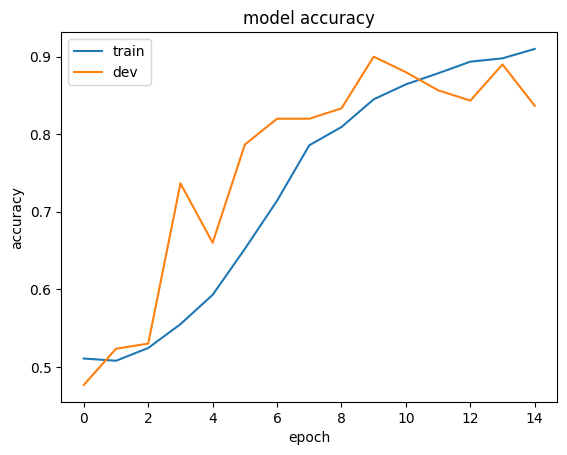

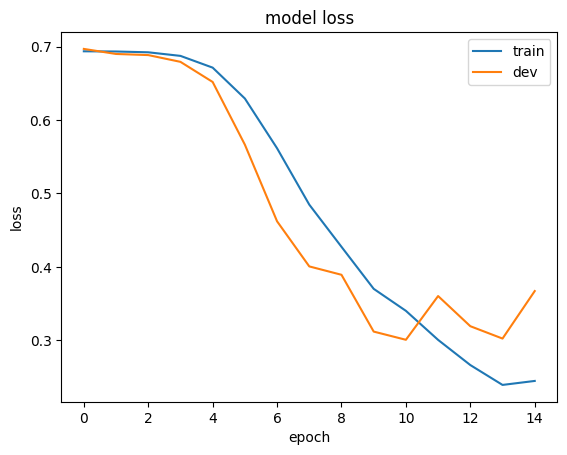

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

##Metrics (Precision, Recall, F1, AUC)

In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc
import numpy as np



train_probs = best_model.predict(X_train_svd)                       #Predict probs for training,dev and test
dev_probs = best_model.predict(X_dev_svd)
test_probs = best_model.predict(X_test_svd)


train_preds = (train_probs > 0.5).astype(int)                                 #To get binary predictions
dev_preds = (dev_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    return precision, recall, f1

train_precision, train_recall, train_f1 = calculate_metrics(y_train, train_preds)
dev_precision, dev_recall, dev_f1 = calculate_metrics(y_dev, dev_preds)
test_precision, test_recall, test_f1 = calculate_metrics(y_test, test_preds)


def calculate_pr_auc(y_true, y_probs):
    pr_auc_scores = []

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc_scores.append(auc(recall, precision))
    return pr_auc_scores

train_pr_auc = calculate_pr_auc(y_train, train_probs)
dev_pr_auc = calculate_pr_auc(y_dev, dev_probs)
test_pr_auc = calculate_pr_auc(y_test, test_probs)


10/10 [==============================] - 0s 2ms/step


In [62]:
for i in range(2):
    print("Class ", z[i], ":   (Training)     (Development)      (Test)")
    print(f"Precision    |  {train_precision[i]:.6f}   |    {dev_precision[i]:.6f}    |   {test_precision[i]:.6f}")
    print(f"Recall       |  {train_recall[i]:.6f}   |    {dev_recall[i]:.6f}    |   {test_recall[i]:.6f}")
    print(f"F1-score     |  {train_f1[i]:.6f}   |    {dev_f1[i]:.6f}    |   {test_f1[i]:.6f}")
    print(f"PR AUC       |  {train_pr_auc[i-1]:.6f}   |    {dev_pr_auc[i-1]:.6f}    |   {test_pr_auc[i-1]:.6f}")
    print("-------------------------------------------------------------")

Class  neg :   (Training)     (Development)      (Test)
Precision    |  0.992308   |    0.915385    |   0.917293
Recall       |  0.934783   |    0.757962    |   0.797386
F1-score     |  0.962687   |    0.829268    |   0.853147
PR AUC       |  0.995746   |    0.944092    |   0.918444
-------------------------------------------------------------
Class  pos :   (Training)     (Development)      (Test)
Precision    |  0.940000   |    0.776471    |   0.814371
Recall       |  0.992958   |    0.923077    |   0.925170
F1-score     |  0.965753   |    0.843450    |   0.866242
PR AUC       |  0.995746   |    0.944092    |   0.918444
-------------------------------------------------------------


In [63]:
def calculate_macro_averaged_scores(y_true, y_pred, y_probs):

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    def calculate_pr_auc(y_true, y_probs):
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        pr_auc = auc(recall, precision)
        return pr_auc

    pr_auc = calculate_pr_auc(y_true, y_probs)


    macro_avg_precision = np.mean(precision)
    macro_avg_recall = np.mean(recall)
    macro_avg_f1 = np.mean(f1)
    macro_avg_pr_auc = np.mean(pr_auc)

    return macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_pr_auc

train_macro_avg_precision, train_macro_avg_recall, train_macro_avg_f1, train_macro_avg_pr_auc = calculate_macro_averaged_scores(y_train, train_preds, train_probs)
dev_macro_avg_precision, dev_macro_avg_recall, dev_macro_avg_f1, dev_macro_avg_pr_auc = calculate_macro_averaged_scores(y_dev, dev_preds, dev_probs)
test_macro_avg_precision, test_macro_avg_recall, test_macro_avg_f1, test_macro_avg_pr_auc = calculate_macro_averaged_scores(y_test, test_preds, test_probs)


print("Macro-averaged Scores for Training Subset:")
print("===========================================")
print(f"Macro-averaged Precision: {train_macro_avg_precision:.6f}")
print(f"Macro-averaged Recall: {train_macro_avg_recall:.6f}")
print(f"Macro-averaged F1-score: {train_macro_avg_f1:.6f}")
print(f"Macro-averaged PR AUC: {train_macro_avg_pr_auc:.6f}")
print()

print("Macro-averaged Scores for Development Subset:")
print("===============================================")
print(f"Macro-averaged Precision: {dev_macro_avg_precision:.6f}")
print(f"Macro-averaged Recall: {dev_macro_avg_recall:.6f}")
print(f"Macro-averaged F1-score: {dev_macro_avg_f1:.6f}")
print(f"Macro-averaged PR AUC: {dev_macro_avg_pr_auc:.6f}")
print()

print("Macro-averaged Scores for Test Subset:")
print("========================================")
print(f"Macro-averaged Precision: {test_macro_avg_precision:.6f}")
print(f"Macro-averaged Recall: {test_macro_avg_recall:.6f}")
print(f"Macro-averaged F1-score: {test_macro_avg_f1:.6f}")
print(f"Macro-averaged PR AUC: {test_macro_avg_pr_auc:.6f}")


Macro-averaged Scores for Training Subset:
Macro-averaged Precision: 0.966154
Macro-averaged Recall: 0.963870
Macro-averaged F1-score: 0.964220
Macro-averaged PR AUC: 0.995746

Macro-averaged Scores for Development Subset:
Macro-averaged Precision: 0.845928
Macro-averaged Recall: 0.840519
Macro-averaged F1-score: 0.836359
Macro-averaged PR AUC: 0.944092

Macro-averaged Scores for Test Subset:
Macro-averaged Precision: 0.865832
Macro-averaged Recall: 0.861278
Macro-averaged F1-score: 0.859694
Macro-averaged PR AUC: 0.918444
